In [1]:
import datetime
import os.path as osp
import platform

import matplotlib
import mplhep
import numpy as np
import torch
import torch_geometric
from pyg_ssl.args import parse_args
from pyg_ssl.mlpf import MLPF
from pyg_ssl.training_mlpf import training_loop_mlpf
from pyg_ssl.training_VICReg import training_loop_VICReg
from pyg_ssl.utils import CLUSTERS_X, TRACKS_X, data_split, load_VICReg, save_MLPF, save_VICReg, distinguish_PFelements, combine_PFelements
from pyg_ssl.VICReg import DECODER, ENCODER

matplotlib.use("Agg")
mplhep.style.use(mplhep.styles.CMS)

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA GeForce GTX 1080 Ti


In [2]:
# load the clic dataset
data_VICReg_train, data_VICReg_valid, data_mlpf_train, data_mlpf_valid, data_test_qcd, data_test_ttbar = data_split(
    "/pfclicvol/data/clic_edm4hep", "quick"
)

Will use data split mode `quick`
Will use 25843 events to train VICReg
Will use 2871 events to validate VICReg
Will use 6461 events to train MLPF
Will use 718 events to validate MLPF


In [3]:
embedding_dim_VICReg = 256
width_encoder = 256 
num_convs = 3
expand_dim = 256
width_decoder = 256

encoder_model_kwargs = {
    "embedding_dim": embedding_dim_VICReg,
    "width": width_encoder,
    "num_convs": num_convs,
    "space_dim": 4,
    "propagate_dim": 22,
    "k": 32,
}

decoder_model_kwargs = {
    "input_dim": embedding_dim_VICReg,
    "output_dim": expand_dim,
    "width": width_decoder,
}

encoder = ENCODER(**encoder_model_kwargs).to(device)
decoder = DECODER(**decoder_model_kwargs).to(device)

print("Encoder", encoder)
print("Decoder", decoder)

Encoder ENCODER(
  (nn1): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (nn2): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv): ModuleList(
    (0): GravNetConv(256, 256, k=32)
    (1): GravNetConv(256, 256, k=32)
    (2): GravNetConv(256, 256, k=32)
  )
)
Decoder DECODER(
  (expander): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features

In [4]:
import json
import pickle as pkl
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


# VICReg loss function
def criterion(x, y, device="cuda", lmbd=25, epsilon=1e-3):
    bs = x.size(0)
    emb = x.size(1)

    std_x = torch.sqrt(x.var(dim=0) + epsilon)
    std_y = torch.sqrt(y.var(dim=0) + epsilon)
    var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))

    invar_loss = F.mse_loss(x, y)

    xNorm = (x - x.mean(0)) / x.std(0)
    yNorm = (y - y.mean(0)) / y.std(0)
    crossCorMat = (xNorm.T @ yNorm) / bs
    cross_loss = (crossCorMat * lmbd - torch.eye(emb, device=torch.device(device)) * lmbd).pow(2).sum()

    return var_loss, invar_loss, cross_loss


@torch.no_grad()
def validation_run(
    device,
    encoder,
    decoder,
    train_loader,
    valid_loader,
    lmbd,
    u,
    v,
):
    with torch.no_grad():
        optimizer = None
        ret = train(
            device,
            encoder,
            decoder,
            train_loader,
            valid_loader,
            optimizer,
            lmbd,
            u,
            v,
        )
    return ret


def train(
    device,
    encoder,
    decoder,
    train_loader,
    valid_loader,
    optimizer,
    lmbd,
    u,
    v,
):

    is_train = not (optimizer is None)

    if is_train:
        print("---->Initiating a training run")
        encoder.train()
        decoder.train()
        loader = train_loader
    else:
        print("---->Initiating a validation run")
        encoder.eval()
        decoder.eval()
        loader = valid_loader

    # initialize loss counters
    losses = 0.0
    var_losses, invar_losses, cross_losses = 0.0, 0.0, 0.0

    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        # make transformation
        tracks, clusters = distinguish_PFelements(batch.to(device))

        # ENCODE
        embedding_tracks, embedding_clusters = encoder(tracks, clusters)
        # DECODE
        out_tracks, out_clusters = decoder(embedding_tracks, embedding_clusters)

        # POOLING
        pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
        pooled_clusters = global_mean_pool(out_clusters, clusters.batch)
        
        # compute loss
        var_loss, invar_loss, cross_loss = criterion(pooled_tracks, pooled_clusters, device, lmbd)
        loss = u * var_loss + v * invar_loss + cross_loss

        # update parameters
        if is_train:
            for param in encoder.parameters():
                param.grad = None
            for param in decoder.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()

        losses += loss.detach()
        var_losses += var_loss.detach()
        invar_losses += invar_loss.detach()
        cross_losses += cross_loss.detach()

    losses = losses.cpu().item() / (len(loader))
    var_losses = var_losses.cpu().item() / (len(loader))
    invar_losses = invar_losses.cpu().item() / (len(loader))
    cross_losses = cross_losses.cpu().item() / (len(loader))

    return losses, var_losses, invar_losses, cross_losses

In [53]:
batch_size_VICReg = 1000
train_loader = torch_geometric.loader.DataLoader(data_VICReg_train, batch_size_VICReg)
valid_loader = torch_geometric.loader.DataLoader(data_VICReg_valid, batch_size_VICReg)

In [54]:
import tqdm

lr = 1e-4
n_epochs = 100
lmbd = 0.1
u = 0.01
v = 0.01
patience = 50

optimizer = torch.optim.SGD(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

torch.cuda.empty_cache()

t0_initial = time.time()

losses_train_tot, losses_train_var, losses_train_invar, losses_train_cross = [], [], [], []
losses_valid_tot, losses_valid_var, losses_valid_invar, losses_valid_cross = [], [], [], []

best_val_loss_tot, best_val_loss_var, best_val_loss_invar, best_val_cross = 99999.9, 99999.9, 99999.9, 99999.9
stale_epochs = 0

for epoch in range(n_epochs):
    t0 = time.time()

    if stale_epochs > patience:
        print("breaking due to stale epochs")
        break

    # training step
    losses_t_tot, losses_t_var, losses_t_invar, losses_t_cross = train(
        device,
        encoder,
        decoder,
        train_loader,
        valid_loader,
        optimizer,
        lmbd,
        u,
        v,
    )

    losses_train_tot.append(losses_t_tot)
    losses_train_var.append(losses_t_var)
    losses_train_invar.append(losses_t_invar)
    losses_train_cross.append(losses_t_cross)

    # validation step
    losses_v_tot, losses_v_var, losses_v_invar, losses_v_cross = validation_run(
        device,
        encoder,
        decoder,
        train_loader,
        valid_loader,
        lmbd,
        u,
        v,
    )

    losses_valid_tot.append(losses_v_tot)
    losses_valid_var.append(losses_v_var)
    losses_valid_invar.append(losses_v_invar)
    losses_valid_cross.append(losses_v_cross)

    # save the lowest value of each component of the loss to print it on the legend of the loss plots
    if losses_v_var < best_val_loss_var:
        best_val_loss_var = losses_v_var
        best_train_loss_var = losses_t_var

    if losses_v_invar < best_val_loss_invar:
        best_val_loss_invar = losses_v_invar
        best_train_loss_invar = losses_t_invar

    if losses_v_cross < best_val_cross:
        best_val_loss_cross = losses_v_cross
        best_train_loss_cross = losses_t_cross

    # early-stopping
    if losses_v_tot < best_val_loss_tot:
        best_val_loss_tot = losses_v_tot
        best_train_loss_tot = losses_t_tot

        stale_epochs = 0

    else:
        stale_epochs += 1

    t1 = time.time()

    epochs_remaining = n_epochs - (epoch + 1)
    time_per_epoch = (t1 - t0_initial) / (epoch + 1)
    eta = epochs_remaining * time_per_epoch / 60

    print(
        f"epoch={epoch + 1} / {n_epochs} "
        + f"train_loss={round(losses_train_tot[epoch], 4)} "
        + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
        + f"stale={stale_epochs} "
        + f"time={round((t1-t0)/60, 2)}m "
        + f"eta={round(eta, 1)}m"
    )

print("----------------------------------------------------------")
print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.56it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=1 / 100 train_loss=4.6347 valid_loss=3.0957 stale=0 time=0.3m eta=30.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.56it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=2 / 100 train_loss=3.7514 valid_loss=3.0436 stale=0 time=0.3m eta=29.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.56it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=3 / 100 train_loss=3.4974 valid_loss=3.0262 stale=0 time=0.3m eta=29.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=4 / 100 train_loss=3.3871 valid_loss=3.0171 stale=0 time=0.31m eta=29.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=5 / 100 train_loss=3.3124 valid_loss=3.0131 stale=0 time=0.31m eta=29.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=6 / 100 train_loss=3.2705 valid_loss=3.0125 stale=0 time=0.31m eta=28.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=7 / 100 train_loss=3.248 valid_loss=3.0109 stale=0 time=0.31m eta=28.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=8 / 100 train_loss=3.1933 valid_loss=3.011 stale=1 time=0.31m eta=28.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=9 / 100 train_loss=3.1586 valid_loss=3.0132 stale=2 time=0.31m eta=27.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=10 / 100 train_loss=3.139 valid_loss=3.0187 stale=3 time=0.31m eta=27.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=11 / 100 train_loss=3.1092 valid_loss=3.0231 stale=4 time=0.31m eta=27.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=12 / 100 train_loss=3.091 valid_loss=3.0236 stale=5 time=0.31m eta=26.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=13 / 100 train_loss=3.0711 valid_loss=3.0295 stale=6 time=0.31m eta=26.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=14 / 100 train_loss=3.0685 valid_loss=3.03 stale=7 time=0.31m eta=26.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=15 / 100 train_loss=3.057 valid_loss=3.039 stale=8 time=0.31m eta=26.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=16 / 100 train_loss=3.0329 valid_loss=3.0442 stale=9 time=0.31m eta=25.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=17 / 100 train_loss=3.0123 valid_loss=3.0487 stale=10 time=0.31m eta=25.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


epoch=18 / 100 train_loss=3.0034 valid_loss=3.0557 stale=11 time=0.31m eta=25.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=19 / 100 train_loss=2.9966 valid_loss=3.062 stale=12 time=0.31m eta=24.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=20 / 100 train_loss=2.977 valid_loss=3.068 stale=13 time=0.31m eta=24.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=21 / 100 train_loss=2.9751 valid_loss=3.0734 stale=14 time=0.31m eta=24.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=22 / 100 train_loss=2.9609 valid_loss=3.0774 stale=15 time=0.31m eta=23.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=23 / 100 train_loss=2.9483 valid_loss=3.0814 stale=16 time=0.31m eta=23.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=24 / 100 train_loss=2.9374 valid_loss=3.0869 stale=17 time=0.31m eta=23.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


epoch=25 / 100 train_loss=2.9324 valid_loss=3.0894 stale=18 time=0.31m eta=23.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=26 / 100 train_loss=2.9232 valid_loss=3.0963 stale=19 time=0.31m eta=22.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=27 / 100 train_loss=2.9266 valid_loss=3.1012 stale=20 time=0.31m eta=22.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=28 / 100 train_loss=2.9139 valid_loss=3.1036 stale=21 time=0.31m eta=22.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=29 / 100 train_loss=2.9049 valid_loss=3.1089 stale=22 time=0.31m eta=21.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=30 / 100 train_loss=2.8999 valid_loss=3.1117 stale=23 time=0.31m eta=21.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=31 / 100 train_loss=2.8923 valid_loss=3.1173 stale=24 time=0.31m eta=21.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=32 / 100 train_loss=2.908 valid_loss=3.1181 stale=25 time=0.31m eta=20.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=33 / 100 train_loss=2.8854 valid_loss=3.1222 stale=26 time=0.31m eta=20.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=34 / 100 train_loss=2.8739 valid_loss=3.1234 stale=27 time=0.31m eta=20.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=35 / 100 train_loss=2.8708 valid_loss=3.1335 stale=28 time=0.31m eta=20.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=36 / 100 train_loss=2.8638 valid_loss=3.1335 stale=29 time=0.31m eta=19.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=37 / 100 train_loss=2.8567 valid_loss=3.1319 stale=30 time=0.31m eta=19.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=38 / 100 train_loss=2.8513 valid_loss=3.1327 stale=31 time=0.31m eta=19.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=39 / 100 train_loss=2.851 valid_loss=3.1335 stale=32 time=0.31m eta=18.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=40 / 100 train_loss=2.8582 valid_loss=3.1332 stale=33 time=0.31m eta=18.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=41 / 100 train_loss=2.8415 valid_loss=3.1343 stale=34 time=0.31m eta=18.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=42 / 100 train_loss=2.8352 valid_loss=3.1342 stale=35 time=0.31m eta=17.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=43 / 100 train_loss=2.8301 valid_loss=3.1375 stale=36 time=0.31m eta=17.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=44 / 100 train_loss=2.832 valid_loss=3.1381 stale=37 time=0.31m eta=17.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=45 / 100 train_loss=2.8265 valid_loss=3.1419 stale=38 time=0.31m eta=16.9m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.55it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=46 / 100 train_loss=2.8165 valid_loss=3.1411 stale=39 time=0.31m eta=16.6m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.06it/s]


epoch=47 / 100 train_loss=2.8163 valid_loss=3.1372 stale=40 time=0.31m eta=16.3m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=48 / 100 train_loss=2.811 valid_loss=3.134 stale=41 time=0.31m eta=16.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=49 / 100 train_loss=2.8089 valid_loss=3.1408 stale=42 time=0.31m eta=15.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=50 / 100 train_loss=2.8112 valid_loss=3.1368 stale=43 time=0.31m eta=15.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=51 / 100 train_loss=2.8026 valid_loss=3.1432 stale=44 time=0.31m eta=15.0m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=52 / 100 train_loss=2.7951 valid_loss=3.142 stale=45 time=0.31m eta=14.7m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]


epoch=53 / 100 train_loss=2.7912 valid_loss=3.1394 stale=46 time=0.31m eta=14.4m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=54 / 100 train_loss=2.7882 valid_loss=3.1418 stale=47 time=0.31m eta=14.1m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=55 / 100 train_loss=2.7847 valid_loss=3.1397 stale=48 time=0.31m eta=13.8m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.03it/s]


epoch=56 / 100 train_loss=2.7806 valid_loss=3.1359 stale=49 time=0.31m eta=13.5m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.05it/s]


epoch=57 / 100 train_loss=2.7773 valid_loss=3.1378 stale=50 time=0.31m eta=13.2m
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:16<00:00,  1.54it/s]


---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.04it/s]

epoch=58 / 100 train_loss=2.7739 valid_loss=3.1388 stale=51 time=0.31m eta=12.9m
breaking due to stale epochs
----------------------------------------------------------
Done with training. Total training time is 17.816min


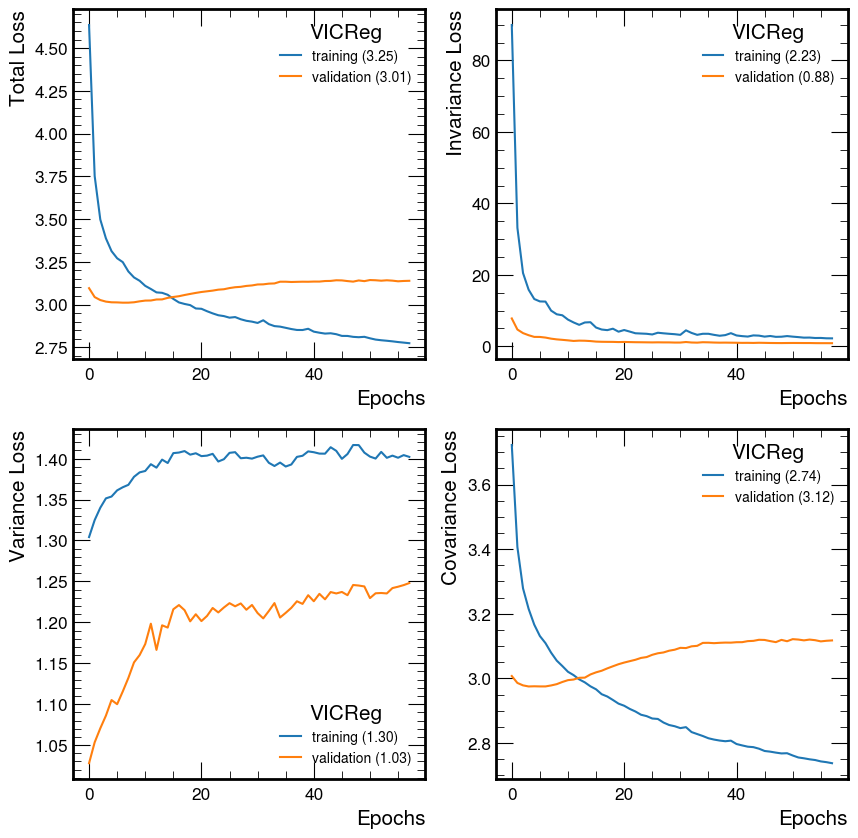

In [55]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax[0,0].plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Total Loss")
ax[0,0].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make variance loss plot
ax[1,0].plot(range(len(losses_train_var)), losses_train_var, label="training ({:.2f})".format(best_train_loss_var))
ax[1,0].plot(range(len(losses_valid_var)), losses_valid_var, label="validation ({:.2f})".format(best_val_loss_var))
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Variance Loss")
ax[1,0].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make invariance loss plot
ax[0,1].plot(range(len(losses_train_invar)), losses_train_invar, label="training ({:.2f})".format(best_train_loss_invar))
ax[0,1].plot(range(len(losses_valid_invar)), losses_valid_invar, label="validation ({:.2f})".format(best_val_loss_invar))
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Invariance Loss")
ax[0,1].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# make covariance loss plot
ax[1,1].plot(range(len(losses_train_cross)), losses_train_cross, label="training ({:.2f})".format(best_train_loss_cross))
ax[1,1].plot(range(len(losses_valid_cross)), losses_valid_cross, label="validation ({:.2f})".format(best_val_loss_cross))
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Covariance Loss")
ax[1,1].legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

# MLPF

In [5]:
### load a vicreg
embedding_dim_VICReg = 256

import pickle as pkl
encoder_state_dict = torch.load(f"/pfclicvol/encoder_best_epoch_weights.pth", map_location=device)

with open(f"/pfclicvol/encoder_model_kwargs.pkl", "rb") as f:
    encoder_model_kwargs = pkl.load(f)
    

encoder = ENCODER(**encoder_model_kwargs)
encoder.load_state_dict(encoder_state_dict)

encoder = encoder.to(device)

In [6]:
print("------> Progressing to MLPF trainings...")
print(f"Will use {len(data_mlpf_train)} events for train")
print(f"Will use {len(data_mlpf_valid)} events for valid")

train_loader = torch_geometric.loader.DataLoader(data_mlpf_train, 500)
valid_loader = torch_geometric.loader.DataLoader(data_mlpf_valid, 500)

input_ = max(CLUSTERS_X, TRACKS_X) + 1  # max cz we pad when we concatenate them & +1 cz there's the `type` feature

------> Progressing to MLPF trainings...
Will use 6461 events for train
Will use 718 events for valid


In [7]:
import json
import math
import pickle as pkl
import time
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import Tensor, nn
from torch.nn import functional as F

matplotlib.use("Agg")

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# keep track of the training step across epochs
istep_global = 0


# from https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha: Optional[Tensor] = None, gamma: float = 0.0, reduction: str = "mean", ignore_index: int = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none", ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "ignore_index", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.0)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss


def compute_weights(device, target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes).to(device=device)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights


@torch.no_grad()
def validation_run(device, encoder, mlpf, train_loader, valid_loader, mode):
    with torch.no_grad():
        optimizer = None
        optimizer_VICReg = None
        ret = train(device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode)
    return ret


def train(device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode):
    """
    A training/validation run over a given epoch that gets called in the training_loop() function.
    When optimizer is set to None, it freezes the model for a validation_run.
    """

    is_train = not (optimizer is None)
    global istep_global

    loss_obj_id = FocalLoss(gamma=2.0)

    if is_train:
        print("---->Initiating a training run")
        mlpf.train()
        loader = train_loader
        if optimizer_VICReg:
            encoder.train()
    else:
        print("---->Initiating a validation run")
        mlpf.eval()
        loader = valid_loader
        if optimizer_VICReg:
            encoder.eval()

    # initialize loss counters
    epoch_loss_total, epoch_loss_id, epoch_loss_momentum, epoch_loss_charge = 0.0, 0.0, 0.0, 0.0

    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        if mode == "ssl":
            # seperate PF-elements
            tracks, clusters = distinguish_PFelements(batch.to(device))

            # ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)

            # concat the inputs with embeddings
            tracks.x = torch.cat([batch.x[batch.x[:, 0] == 1], embedding_tracks], axis=1)
            clusters.x = torch.cat([batch.x[batch.x[:, 0] == 2], embedding_clusters], axis=1)

            # combine PF-elements
            event = combine_PFelements(tracks, clusters)

        elif mode == "native":
            event = batch.to(device)

        # make mlpf forward pass
        event_on_device = event.to(device)
        pred_ids_one_hot, pred_momentum, pred_charge = mlpf(event_on_device)
        target_ids = event_on_device.ygen_id

        target_momentum = event_on_device.ygen[:, 1:].to(dtype=torch.float32)
        target_charge = (event_on_device.ygen[:, 0] + 1).to(dtype=torch.float32)  # -1, 0, 1

        loss_id = 100 * loss_obj_id(pred_ids_one_hot, target_ids)
        # loss_id_old = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids)  # for classifying PID

        # for regression, mask the loss in cases there is no true particle
        msk_true_particle = torch.unsqueeze((target_ids != 0).to(dtype=torch.float32), axis=-1)
        loss_momentum = 10 * torch.nn.functional.huber_loss(
            pred_momentum * msk_true_particle, target_momentum * msk_true_particle
        )  # for regressing p4

        loss_charge = torch.nn.functional.cross_entropy(
            pred_charge * msk_true_particle, (target_charge * msk_true_particle[:, 0]).to(dtype=torch.int64)
        )  # for predicting charge
        loss = loss_id + loss_momentum + loss_charge

        if is_train:
            istep_global += 1

        # update parameters
        if is_train:
            for param in mlpf.parameters():
                param.grad = None
            if optimizer_VICReg:
                for param in encoder.parameters():
                    param.grad = None
            loss.backward()
            optimizer.step()

        epoch_loss_total += loss.detach()
        epoch_loss_id += loss_id.detach()
        epoch_loss_momentum += loss_momentum.detach()
        epoch_loss_charge += loss_charge.detach()

    epoch_loss_total = epoch_loss_total.cpu().item() / len(loader)
    epoch_loss_id = epoch_loss_id.cpu().item() / len(loader)
    epoch_loss_momentum = epoch_loss_momentum.cpu().item() / len(loader)
    epoch_loss_charge = epoch_loss_charge.cpu().item() / len(loader)

    print(
        "loss_id={:.2f} loss_momentum={:.2f} loss_charge={:.2f}".format(
            epoch_loss_id, epoch_loss_momentum, epoch_loss_charge
        )
    )
    return epoch_loss_total, epoch_loss_id, epoch_loss_momentum

# SSL

In [26]:
ssl = 1

mlpf_model_kwargs = {
    "input_dim": input_,
    "width": 256,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": ssl,
    "VICReg_embedding_dim": embedding_dim_VICReg
}

mlpf = MLPF(**mlpf_model_kwargs).to(device)
print(mlpf)

if ssl:
    mode = "ssl"
else:
    mode = "native"

MLPF(
  (nn_id): Sequential(
    (0): Linear(in_features=272, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (15): Linear(in_features=256, out_features=6, bias=True)
  )
  (nn_pt): Sequential(
    (0): Linear(in_features=278, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout

In [27]:
n_epochs = 300
lr = 5e-5
patience = 50
FineTune_VICReg=False

# make mlpf specific directory
print(f"- Training {mode} MLPF over {n_epochs} epochs")

t0_initial = time.time()

losses_train_tot, losses_train_id, losses_train_momentum = [], [], []
losses_valid_tot, losses_valid_id, losses_valid_momentum = [], [], []

best_val_loss_tot, best_val_loss_id, best_val_loss_momentum = 99999.9, 99999.9, 99999.9
stale_epochs = 0

optimizer = torch.optim.AdamW(mlpf.parameters(), lr=lr)
if FineTune_VICReg:
    print("Will finetune VICReg during mlpf training")
    optimizer_VICReg = torch.optim.SGD(encoder.parameters(), lr=lr * 0.1)
else:
    print("Will fix VICReg during mlpf training")
    optimizer_VICReg = None

# set VICReg to evaluation mode
encoder.eval()

for epoch in range(n_epochs):
    t0 = time.time()

    if stale_epochs > patience:
        print("breaking due to stale epochs")
        break

    # training step
    losses_t_tot, losses_t_id, losses_t_momentum = train(
        device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode
    )
    losses_train_tot.append(losses_t_tot)
    losses_train_id.append(losses_t_id)
    losses_train_momentum.append(losses_t_momentum)

    # validation step
    losses_v_tot, losses_v_id, losses_v_momentum = validation_run(
        device, encoder, mlpf, train_loader, valid_loader, mode
    )
    losses_valid_tot.append(losses_v_tot)
    losses_valid_id.append(losses_v_id)
    losses_valid_momentum.append(losses_v_momentum)

    if losses_v_id < best_val_loss_id:
        best_val_loss_id = losses_v_id
        best_train_loss_id = losses_t_id

    if losses_v_momentum < best_val_loss_momentum:
        best_val_loss_momentum = losses_v_momentum
        best_train_loss_momentum = losses_t_momentum

    # early-stopping
    if losses_v_tot < best_val_loss_tot:
        best_val_loss_tot = losses_v_tot
        best_train_loss_tot = losses_t_tot

        stale_epochs = 0
    else:
        stale_epochs += 1

    t1 = time.time()

    epochs_remaining = n_epochs - (epoch + 1)
    time_per_epoch = (t1 - t0_initial) / (epoch + 1)
    eta = epochs_remaining * time_per_epoch / 60

    print(
        f"epoch={epoch + 1} / {n_epochs} "
        + f"train_loss={round(losses_train_tot[epoch], 4)} "
        + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
        + f"stale={stale_epochs} "
        + f"time={round((t1-t0)/60, 2)}m "
        + f"eta={round(eta, 1)}m"
    )

    print("----------------------------------------------------------")
print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

- Training ssl MLPF over 300 epochs
Will fix VICReg during mlpf training
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=115.02 loss_momentum=2.42 loss_charge=1.07
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=64.05 loss_momentum=1.78 loss_charge=0.87
epoch=1 / 300 train_loss=118.5141 valid_loss=66.7009 stale=0 time=0.19m eta=57.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=77.55 loss_momentum=2.14 loss_charge=0.93
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=48.63 loss_momentum=1.76 loss_charge=0.71
epoch=2 / 300 train_loss=80.6183 valid_loss=51.1069 stale=0 time=0.19m eta=56.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=60.22 loss_momentum=2.01 loss_charge=0.82
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=43.12 loss_momentum=1.73 loss_charge=0.65
epoch=3 / 300 train_loss=63.0385 valid_loss=45.5033 stale=0 time=0.19m eta=56.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=49.82 loss_momentum=1.93 loss_charge=0.73
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=40.74 loss_momentum=1.73 loss_charge=0.64
epoch=4 / 300 train_loss=52.486 valid_loss=43.1094 stale=0 time=0.19m eta=56.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=43.93 loss_momentum=1.89 loss_charge=0.69
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=40.04 loss_momentum=1.73 loss_charge=0.63
epoch=5 / 300 train_loss=46.5119 valid_loss=42.4 stale=0 time=0.19m eta=55.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=40.45 loss_momentum=1.86 loss_charge=0.66
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


loss_id=38.38 loss_momentum=1.72 loss_charge=0.63
epoch=6 / 300 train_loss=42.9822 valid_loss=40.7326 stale=0 time=0.18m eta=55.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=37.98 loss_momentum=1.85 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


loss_id=35.88 loss_momentum=1.72 loss_charge=0.63
epoch=7 / 300 train_loss=40.4782 valid_loss=38.2342 stale=0 time=0.19m eta=55.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=36.19 loss_momentum=1.83 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=33.96 loss_momentum=1.72 loss_charge=0.63
epoch=8 / 300 train_loss=38.6736 valid_loss=36.305 stale=0 time=0.19m eta=55.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=34.89 loss_momentum=1.82 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=32.62 loss_momentum=1.72 loss_charge=0.63
epoch=9 / 300 train_loss=37.3588 valid_loss=34.9689 stale=0 time=0.2m eta=55.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=33.86 loss_momentum=1.82 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=31.80 loss_momentum=1.72 loss_charge=0.63
epoch=10 / 300 train_loss=36.3197 valid_loss=34.1463 stale=0 time=0.19m eta=54.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=33.13 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=31.22 loss_momentum=1.71 loss_charge=0.63
epoch=11 / 300 train_loss=35.5847 valid_loss=33.5571 stale=0 time=0.19m eta=54.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=32.47 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=30.74 loss_momentum=1.71 loss_charge=0.63
epoch=12 / 300 train_loss=34.9138 valid_loss=33.0845 stale=0 time=0.18m eta=54.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=31.98 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=30.33 loss_momentum=1.71 loss_charge=0.63
epoch=13 / 300 train_loss=34.4232 valid_loss=32.6679 stale=0 time=0.19m eta=54.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=31.53 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


loss_id=29.99 loss_momentum=1.71 loss_charge=0.63
epoch=14 / 300 train_loss=33.9662 valid_loss=32.3251 stale=0 time=0.2m eta=54.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=31.18 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=29.67 loss_momentum=1.71 loss_charge=0.63
epoch=15 / 300 train_loss=33.6104 valid_loss=32.0053 stale=0 time=0.19m eta=54.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=30.90 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=29.38 loss_momentum=1.70 loss_charge=0.63
epoch=16 / 300 train_loss=33.3248 valid_loss=31.712 stale=0 time=0.19m eta=53.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=30.58 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=29.15 loss_momentum=1.70 loss_charge=0.63
epoch=17 / 300 train_loss=33.0028 valid_loss=31.4826 stale=0 time=0.2m eta=53.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=30.36 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


loss_id=28.93 loss_momentum=1.70 loss_charge=0.63
epoch=18 / 300 train_loss=32.7857 valid_loss=31.2513 stale=0 time=0.19m eta=53.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=30.13 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.56it/s]


loss_id=28.74 loss_momentum=1.70 loss_charge=0.63
epoch=19 / 300 train_loss=32.5511 valid_loss=31.065 stale=0 time=0.19m eta=53.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=29.91 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.59it/s]


loss_id=28.58 loss_momentum=1.69 loss_charge=0.63
epoch=20 / 300 train_loss=32.3288 valid_loss=30.9039 stale=0 time=0.18m eta=53.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=29.77 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=28.42 loss_momentum=1.69 loss_charge=0.63
epoch=21 / 300 train_loss=32.1841 valid_loss=30.7403 stale=0 time=0.19m eta=52.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=29.63 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


loss_id=28.28 loss_momentum=1.69 loss_charge=0.63
epoch=22 / 300 train_loss=32.0417 valid_loss=30.595 stale=0 time=0.19m eta=52.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=29.46 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=28.16 loss_momentum=1.68 loss_charge=0.63
epoch=23 / 300 train_loss=31.8688 valid_loss=30.4734 stale=0 time=0.19m eta=52.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=29.31 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


loss_id=28.06 loss_momentum=1.68 loss_charge=0.63
epoch=24 / 300 train_loss=31.7176 valid_loss=30.3615 stale=0 time=0.2m eta=52.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=29.17 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=27.94 loss_momentum=1.68 loss_charge=0.63
epoch=25 / 300 train_loss=31.5782 valid_loss=30.2468 stale=0 time=0.19m eta=52.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.11it/s]


loss_id=29.07 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=27.87 loss_momentum=1.67 loss_charge=0.63
epoch=26 / 300 train_loss=31.4735 valid_loss=30.169 stale=0 time=0.21m eta=52.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=29.00 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=27.78 loss_momentum=1.67 loss_charge=0.63
epoch=27 / 300 train_loss=31.3995 valid_loss=30.0786 stale=0 time=0.19m eta=52.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=28.84 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=27.71 loss_momentum=1.67 loss_charge=0.63
epoch=28 / 300 train_loss=31.2349 valid_loss=30.0007 stale=0 time=0.19m eta=51.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=28.73 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=27.64 loss_momentum=1.67 loss_charge=0.63
epoch=29 / 300 train_loss=31.1219 valid_loss=29.9327 stale=0 time=0.2m eta=51.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=28.63 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


loss_id=27.58 loss_momentum=1.66 loss_charge=0.63
epoch=30 / 300 train_loss=31.0208 valid_loss=29.8663 stale=0 time=0.19m eta=51.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=28.55 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


loss_id=27.51 loss_momentum=1.66 loss_charge=0.63
epoch=31 / 300 train_loss=30.9318 valid_loss=29.7937 stale=0 time=0.19m eta=51.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=28.52 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


loss_id=27.44 loss_momentum=1.65 loss_charge=0.63
epoch=32 / 300 train_loss=30.8991 valid_loss=29.7223 stale=0 time=0.19m eta=51.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=28.40 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.59it/s]


loss_id=27.40 loss_momentum=1.65 loss_charge=0.63
epoch=33 / 300 train_loss=30.7821 valid_loss=29.6731 stale=0 time=0.19m eta=50.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=28.31 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


loss_id=27.35 loss_momentum=1.65 loss_charge=0.63
epoch=34 / 300 train_loss=30.685 valid_loss=29.6265 stale=0 time=0.19m eta=50.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=28.24 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=27.30 loss_momentum=1.64 loss_charge=0.63
epoch=35 / 300 train_loss=30.6122 valid_loss=29.5623 stale=0 time=0.2m eta=50.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=28.20 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


loss_id=27.25 loss_momentum=1.64 loss_charge=0.63
epoch=36 / 300 train_loss=30.565 valid_loss=29.5165 stale=0 time=0.19m eta=50.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=28.12 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=27.20 loss_momentum=1.63 loss_charge=0.63
epoch=37 / 300 train_loss=30.4853 valid_loss=29.4569 stale=0 time=0.19m eta=50.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=28.06 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.57it/s]


loss_id=27.16 loss_momentum=1.63 loss_charge=0.62
epoch=38 / 300 train_loss=30.4226 valid_loss=29.4116 stale=0 time=0.19m eta=50.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=27.99 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=27.11 loss_momentum=1.62 loss_charge=0.62
epoch=39 / 300 train_loss=30.3475 valid_loss=29.3597 stale=0 time=0.19m eta=49.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=27.96 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=27.07 loss_momentum=1.62 loss_charge=0.62
epoch=40 / 300 train_loss=30.3127 valid_loss=29.3107 stale=0 time=0.18m eta=49.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=27.86 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=27.01 loss_momentum=1.61 loss_charge=0.62
epoch=41 / 300 train_loss=30.209 valid_loss=29.2537 stale=0 time=0.19m eta=49.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=27.82 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=26.96 loss_momentum=1.61 loss_charge=0.62
epoch=42 / 300 train_loss=30.1582 valid_loss=29.1931 stale=0 time=0.2m eta=49.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=27.79 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


loss_id=26.91 loss_momentum=1.60 loss_charge=0.62
epoch=43 / 300 train_loss=30.1307 valid_loss=29.1416 stale=0 time=0.2m eta=49.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=27.70 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=26.86 loss_momentum=1.60 loss_charge=0.62
epoch=44 / 300 train_loss=30.036 valid_loss=29.0858 stale=0 time=0.2m eta=49.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=27.68 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=26.81 loss_momentum=1.60 loss_charge=0.62
epoch=45 / 300 train_loss=30.0122 valid_loss=29.0354 stale=0 time=0.19m eta=48.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=27.63 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=26.76 loss_momentum=1.59 loss_charge=0.62
epoch=46 / 300 train_loss=29.95 valid_loss=28.982 stale=0 time=0.19m eta=48.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=27.58 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


loss_id=26.71 loss_momentum=1.59 loss_charge=0.62
epoch=47 / 300 train_loss=29.8964 valid_loss=28.9226 stale=0 time=0.2m eta=48.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=27.52 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


loss_id=26.66 loss_momentum=1.59 loss_charge=0.62
epoch=48 / 300 train_loss=29.8373 valid_loss=28.8709 stale=0 time=0.19m eta=48.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=27.50 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=26.60 loss_momentum=1.58 loss_charge=0.62
epoch=49 / 300 train_loss=29.8081 valid_loss=28.8093 stale=0 time=0.2m eta=48.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=27.43 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=26.55 loss_momentum=1.58 loss_charge=0.62
epoch=50 / 300 train_loss=29.7442 valid_loss=28.7571 stale=0 time=0.2m eta=47.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=27.37 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=26.49 loss_momentum=1.58 loss_charge=0.62
epoch=51 / 300 train_loss=29.6786 valid_loss=28.6898 stale=0 time=0.19m eta=47.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=27.33 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=26.42 loss_momentum=1.58 loss_charge=0.62
epoch=52 / 300 train_loss=29.6379 valid_loss=28.6248 stale=0 time=0.2m eta=47.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=27.29 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=26.37 loss_momentum=1.58 loss_charge=0.62
epoch=53 / 300 train_loss=29.5904 valid_loss=28.5695 stale=0 time=0.2m eta=47.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=27.24 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


loss_id=26.30 loss_momentum=1.57 loss_charge=0.62
epoch=54 / 300 train_loss=29.5345 valid_loss=28.5027 stale=0 time=0.19m eta=47.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=27.16 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=26.23 loss_momentum=1.57 loss_charge=0.62
epoch=55 / 300 train_loss=29.456 valid_loss=28.429 stale=0 time=0.19m eta=47.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=27.11 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


loss_id=26.17 loss_momentum=1.57 loss_charge=0.62
epoch=56 / 300 train_loss=29.4041 valid_loss=28.3602 stale=0 time=0.2m eta=46.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=27.04 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=26.09 loss_momentum=1.57 loss_charge=0.62
epoch=57 / 300 train_loss=29.3288 valid_loss=28.2779 stale=0 time=0.19m eta=46.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=27.02 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=26.01 loss_momentum=1.56 loss_charge=0.62
epoch=58 / 300 train_loss=29.3044 valid_loss=28.1956 stale=0 time=0.19m eta=46.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=26.94 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=25.93 loss_momentum=1.56 loss_charge=0.62
epoch=59 / 300 train_loss=29.2254 valid_loss=28.1206 stale=0 time=0.19m eta=46.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.14it/s]


loss_id=26.91 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=25.86 loss_momentum=1.56 loss_charge=0.62
epoch=60 / 300 train_loss=29.1876 valid_loss=28.0442 stale=0 time=0.2m eta=46.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=26.83 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=25.79 loss_momentum=1.56 loss_charge=0.62
epoch=61 / 300 train_loss=29.1059 valid_loss=27.9693 stale=0 time=0.2m eta=45.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=26.80 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=25.70 loss_momentum=1.56 loss_charge=0.62
epoch=62 / 300 train_loss=29.0789 valid_loss=27.8789 stale=0 time=0.2m eta=45.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=26.71 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


loss_id=25.62 loss_momentum=1.56 loss_charge=0.62
epoch=63 / 300 train_loss=28.9835 valid_loss=27.8016 stale=0 time=0.19m eta=45.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=26.67 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=25.53 loss_momentum=1.55 loss_charge=0.62
epoch=64 / 300 train_loss=28.9395 valid_loss=27.7049 stale=0 time=0.2m eta=45.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=26.61 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


loss_id=25.46 loss_momentum=1.55 loss_charge=0.62
epoch=65 / 300 train_loss=28.8814 valid_loss=27.6385 stale=0 time=0.2m eta=45.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=26.55 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=25.36 loss_momentum=1.55 loss_charge=0.62
epoch=66 / 300 train_loss=28.8195 valid_loss=27.5376 stale=0 time=0.19m eta=45.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=26.49 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.66it/s]


loss_id=25.27 loss_momentum=1.55 loss_charge=0.62
epoch=67 / 300 train_loss=28.7541 valid_loss=27.4446 stale=0 time=0.2m eta=44.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=26.43 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=25.18 loss_momentum=1.55 loss_charge=0.62
epoch=68 / 300 train_loss=28.6935 valid_loss=27.3538 stale=0 time=0.2m eta=44.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=26.39 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=25.10 loss_momentum=1.55 loss_charge=0.62
epoch=69 / 300 train_loss=28.6474 valid_loss=27.269 stale=0 time=0.19m eta=44.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=26.29 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


loss_id=25.00 loss_momentum=1.54 loss_charge=0.62
epoch=70 / 300 train_loss=28.5443 valid_loss=27.1658 stale=0 time=0.2m eta=44.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=26.22 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=24.91 loss_momentum=1.54 loss_charge=0.62
epoch=71 / 300 train_loss=28.4758 valid_loss=27.0759 stale=0 time=0.19m eta=44.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.14it/s]


loss_id=26.17 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=24.82 loss_momentum=1.54 loss_charge=0.62
epoch=72 / 300 train_loss=28.4196 valid_loss=26.9832 stale=0 time=0.2m eta=43.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=26.09 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=24.71 loss_momentum=1.54 loss_charge=0.62
epoch=73 / 300 train_loss=28.3421 valid_loss=26.8779 stale=0 time=0.19m eta=43.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=26.04 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=24.62 loss_momentum=1.54 loss_charge=0.62
epoch=74 / 300 train_loss=28.2931 valid_loss=26.7854 stale=0 time=0.19m eta=43.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=25.95 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


loss_id=24.53 loss_momentum=1.54 loss_charge=0.62
epoch=75 / 300 train_loss=28.1966 valid_loss=26.6903 stale=0 time=0.19m eta=43.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=25.89 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=24.43 loss_momentum=1.54 loss_charge=0.62
epoch=76 / 300 train_loss=28.1313 valid_loss=26.5948 stale=0 time=0.2m eta=43.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=25.79 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


loss_id=24.31 loss_momentum=1.54 loss_charge=0.62
epoch=77 / 300 train_loss=28.0297 valid_loss=26.474 stale=0 time=0.2m eta=43.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=25.71 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=24.21 loss_momentum=1.54 loss_charge=0.62
epoch=78 / 300 train_loss=27.95 valid_loss=26.3706 stale=0 time=0.19m eta=42.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=25.63 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=24.10 loss_momentum=1.54 loss_charge=0.62
epoch=79 / 300 train_loss=27.8733 valid_loss=26.2587 stale=0 time=0.19m eta=42.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=25.58 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=24.01 loss_momentum=1.54 loss_charge=0.62
epoch=80 / 300 train_loss=27.8201 valid_loss=26.1732 stale=0 time=0.19m eta=42.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=25.48 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


loss_id=23.90 loss_momentum=1.53 loss_charge=0.62
epoch=81 / 300 train_loss=27.7149 valid_loss=26.0578 stale=0 time=0.19m eta=42.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=25.41 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=23.81 loss_momentum=1.53 loss_charge=0.62
epoch=82 / 300 train_loss=27.6457 valid_loss=25.9694 stale=0 time=0.19m eta=42.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=25.28 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


loss_id=23.71 loss_momentum=1.53 loss_charge=0.62
epoch=83 / 300 train_loss=27.5134 valid_loss=25.869 stale=0 time=0.19m eta=41.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=25.22 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=23.61 loss_momentum=1.53 loss_charge=0.62
epoch=84 / 300 train_loss=27.4591 valid_loss=25.7674 stale=0 time=0.19m eta=41.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=25.14 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


loss_id=23.51 loss_momentum=1.53 loss_charge=0.62
epoch=85 / 300 train_loss=27.3724 valid_loss=25.6682 stale=0 time=0.19m eta=41.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=25.06 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


loss_id=23.42 loss_momentum=1.53 loss_charge=0.62
epoch=86 / 300 train_loss=27.29 valid_loss=25.5713 stale=0 time=0.19m eta=41.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=24.97 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=23.31 loss_momentum=1.53 loss_charge=0.62
epoch=87 / 300 train_loss=27.2063 valid_loss=25.4675 stale=0 time=0.19m eta=41.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=24.88 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


loss_id=23.22 loss_momentum=1.53 loss_charge=0.62
epoch=88 / 300 train_loss=27.1133 valid_loss=25.3731 stale=0 time=0.2m eta=40.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=24.77 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


loss_id=23.12 loss_momentum=1.53 loss_charge=0.62
epoch=89 / 300 train_loss=26.9962 valid_loss=25.269 stale=0 time=0.19m eta=40.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=24.70 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=23.03 loss_momentum=1.53 loss_charge=0.62
epoch=90 / 300 train_loss=26.9293 valid_loss=25.1776 stale=0 time=0.2m eta=40.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=24.60 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=22.93 loss_momentum=1.53 loss_charge=0.62
epoch=91 / 300 train_loss=26.833 valid_loss=25.0843 stale=0 time=0.19m eta=40.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=24.53 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


loss_id=22.84 loss_momentum=1.53 loss_charge=0.62
epoch=92 / 300 train_loss=26.757 valid_loss=24.9894 stale=0 time=0.19m eta=40.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=24.40 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=22.74 loss_momentum=1.52 loss_charge=0.62
epoch=93 / 300 train_loss=26.6262 valid_loss=24.8901 stale=0 time=0.19m eta=39.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=24.31 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=22.65 loss_momentum=1.52 loss_charge=0.62
epoch=94 / 300 train_loss=26.531 valid_loss=24.8029 stale=0 time=0.19m eta=39.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=24.23 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=22.57 loss_momentum=1.52 loss_charge=0.62
epoch=95 / 300 train_loss=26.4538 valid_loss=24.7169 stale=0 time=0.19m eta=39.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=24.15 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


loss_id=22.50 loss_momentum=1.52 loss_charge=0.62
epoch=96 / 300 train_loss=26.3782 valid_loss=24.6476 stale=0 time=0.19m eta=39.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=24.07 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


loss_id=22.44 loss_momentum=1.52 loss_charge=0.62
epoch=97 / 300 train_loss=26.2891 valid_loss=24.5827 stale=0 time=0.2m eta=39.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=23.96 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=22.37 loss_momentum=1.52 loss_charge=0.62
epoch=98 / 300 train_loss=26.1799 valid_loss=24.516 stale=0 time=0.19m eta=38.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=23.91 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=22.30 loss_momentum=1.52 loss_charge=0.62
epoch=99 / 300 train_loss=26.1323 valid_loss=24.4474 stale=0 time=0.2m eta=38.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=23.82 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=22.25 loss_momentum=1.52 loss_charge=0.62
epoch=100 / 300 train_loss=26.0376 valid_loss=24.391 stale=0 time=0.18m eta=38.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.27it/s]


loss_id=23.78 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


loss_id=22.18 loss_momentum=1.52 loss_charge=0.62
epoch=101 / 300 train_loss=25.9973 valid_loss=24.3238 stale=0 time=0.18m eta=38.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=23.69 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=22.13 loss_momentum=1.52 loss_charge=0.62
epoch=102 / 300 train_loss=25.9112 valid_loss=24.2708 stale=0 time=0.19m eta=38.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=23.65 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=22.06 loss_momentum=1.52 loss_charge=0.62
epoch=103 / 300 train_loss=25.8639 valid_loss=24.2016 stale=0 time=0.19m eta=37.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=23.55 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=21.99 loss_momentum=1.52 loss_charge=0.62
epoch=104 / 300 train_loss=25.7662 valid_loss=24.1345 stale=0 time=0.2m eta=37.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=23.50 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=21.95 loss_momentum=1.51 loss_charge=0.62
epoch=105 / 300 train_loss=25.7177 valid_loss=24.0876 stale=0 time=0.19m eta=37.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.14it/s]


loss_id=23.46 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=21.90 loss_momentum=1.51 loss_charge=0.62
epoch=106 / 300 train_loss=25.6738 valid_loss=24.0408 stale=0 time=0.2m eta=37.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=23.39 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


loss_id=21.85 loss_momentum=1.51 loss_charge=0.62
epoch=107 / 300 train_loss=25.6036 valid_loss=23.9875 stale=0 time=0.2m eta=37.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=23.30 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.58it/s]


loss_id=21.79 loss_momentum=1.51 loss_charge=0.62
epoch=108 / 300 train_loss=25.5099 valid_loss=23.9254 stale=0 time=0.19m eta=36.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=23.29 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=21.75 loss_momentum=1.51 loss_charge=0.62
epoch=109 / 300 train_loss=25.4979 valid_loss=23.8799 stale=0 time=0.19m eta=36.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=23.21 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=21.69 loss_momentum=1.51 loss_charge=0.62
epoch=110 / 300 train_loss=25.42 valid_loss=23.8256 stale=0 time=0.19m eta=36.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=23.17 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=21.65 loss_momentum=1.51 loss_charge=0.62
epoch=111 / 300 train_loss=25.3734 valid_loss=23.7849 stale=0 time=0.19m eta=36.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=23.12 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=21.61 loss_momentum=1.51 loss_charge=0.62
epoch=112 / 300 train_loss=25.3233 valid_loss=23.7376 stale=0 time=0.19m eta=36.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=23.07 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


loss_id=21.57 loss_momentum=1.51 loss_charge=0.62
epoch=113 / 300 train_loss=25.278 valid_loss=23.6959 stale=0 time=0.19m eta=35.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=23.01 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=21.52 loss_momentum=1.50 loss_charge=0.62
epoch=114 / 300 train_loss=25.2089 valid_loss=23.6453 stale=0 time=0.2m eta=35.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=22.98 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=21.47 loss_momentum=1.50 loss_charge=0.62
epoch=115 / 300 train_loss=25.1802 valid_loss=23.6034 stale=0 time=0.2m eta=35.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=22.90 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


loss_id=21.44 loss_momentum=1.50 loss_charge=0.62
epoch=116 / 300 train_loss=25.1013 valid_loss=23.5673 stale=0 time=0.2m eta=35.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=22.87 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=21.40 loss_momentum=1.50 loss_charge=0.62
epoch=117 / 300 train_loss=25.065 valid_loss=23.5217 stale=0 time=0.19m eta=35.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=22.81 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=21.36 loss_momentum=1.50 loss_charge=0.62
epoch=118 / 300 train_loss=25.0043 valid_loss=23.482 stale=0 time=0.19m eta=35.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=22.76 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=21.33 loss_momentum=1.50 loss_charge=0.62
epoch=119 / 300 train_loss=24.9575 valid_loss=23.4512 stale=0 time=0.19m eta=34.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=22.71 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=21.29 loss_momentum=1.50 loss_charge=0.62
epoch=120 / 300 train_loss=24.9001 valid_loss=23.4066 stale=0 time=0.19m eta=34.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=22.69 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=21.26 loss_momentum=1.49 loss_charge=0.62
epoch=121 / 300 train_loss=24.8789 valid_loss=23.3744 stale=0 time=0.2m eta=34.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=22.62 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.56it/s]


loss_id=21.22 loss_momentum=1.49 loss_charge=0.62
epoch=122 / 300 train_loss=24.811 valid_loss=23.3404 stale=0 time=0.2m eta=34.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=22.59 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=21.19 loss_momentum=1.49 loss_charge=0.62
epoch=123 / 300 train_loss=24.7801 valid_loss=23.304 stale=0 time=0.19m eta=34.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=22.53 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=21.16 loss_momentum=1.49 loss_charge=0.62
epoch=124 / 300 train_loss=24.7181 valid_loss=23.2772 stale=0 time=0.19m eta=33.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.13it/s]


loss_id=22.48 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=21.12 loss_momentum=1.49 loss_charge=0.62
epoch=125 / 300 train_loss=24.664 valid_loss=23.2373 stale=0 time=0.2m eta=33.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=22.44 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=21.10 loss_momentum=1.49 loss_charge=0.62
epoch=126 / 300 train_loss=24.6231 valid_loss=23.2127 stale=0 time=0.19m eta=33.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=22.40 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=21.07 loss_momentum=1.49 loss_charge=0.62
epoch=127 / 300 train_loss=24.5872 valid_loss=23.1841 stale=0 time=0.18m eta=33.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=22.37 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


loss_id=21.05 loss_momentum=1.49 loss_charge=0.62
epoch=128 / 300 train_loss=24.5582 valid_loss=23.1588 stale=0 time=0.19m eta=33.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=22.33 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=21.02 loss_momentum=1.49 loss_charge=0.62
epoch=129 / 300 train_loss=24.5132 valid_loss=23.1289 stale=0 time=0.19m eta=32.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=22.29 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=20.99 loss_momentum=1.48 loss_charge=0.62
epoch=130 / 300 train_loss=24.4717 valid_loss=23.1001 stale=0 time=0.19m eta=32.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=22.26 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.97 loss_momentum=1.48 loss_charge=0.62
epoch=131 / 300 train_loss=24.4391 valid_loss=23.0813 stale=0 time=0.2m eta=32.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=22.22 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.95 loss_momentum=1.48 loss_charge=0.62
epoch=132 / 300 train_loss=24.4011 valid_loss=23.053 stale=0 time=0.19m eta=32.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=22.19 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


loss_id=20.92 loss_momentum=1.48 loss_charge=0.62
epoch=133 / 300 train_loss=24.3653 valid_loss=23.0295 stale=0 time=0.19m eta=32.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=22.14 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.90 loss_momentum=1.48 loss_charge=0.62
epoch=134 / 300 train_loss=24.3206 valid_loss=23.008 stale=0 time=0.19m eta=31.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=22.12 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.89 loss_momentum=1.48 loss_charge=0.62
epoch=135 / 300 train_loss=24.2998 valid_loss=22.9935 stale=0 time=0.19m eta=31.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=22.10 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.87 loss_momentum=1.48 loss_charge=0.62
epoch=136 / 300 train_loss=24.2777 valid_loss=22.9739 stale=0 time=0.19m eta=31.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=22.05 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.84 loss_momentum=1.48 loss_charge=0.62
epoch=137 / 300 train_loss=24.2291 valid_loss=22.9464 stale=0 time=0.19m eta=31.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=22.02 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.83 loss_momentum=1.48 loss_charge=0.62
epoch=138 / 300 train_loss=24.1889 valid_loss=22.9306 stale=0 time=0.2m eta=31.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=22.01 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.81 loss_momentum=1.48 loss_charge=0.62
epoch=139 / 300 train_loss=24.1854 valid_loss=22.9107 stale=0 time=0.19m eta=30.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.95 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


loss_id=20.79 loss_momentum=1.48 loss_charge=0.62
epoch=140 / 300 train_loss=24.1247 valid_loss=22.8914 stale=0 time=0.19m eta=30.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.95 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=20.78 loss_momentum=1.48 loss_charge=0.62
epoch=141 / 300 train_loss=24.1178 valid_loss=22.8779 stale=0 time=0.19m eta=30.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.91 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


loss_id=20.76 loss_momentum=1.47 loss_charge=0.62
epoch=142 / 300 train_loss=24.0813 valid_loss=22.8617 stale=0 time=0.19m eta=30.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.91 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.72it/s]


loss_id=20.75 loss_momentum=1.47 loss_charge=0.62
epoch=143 / 300 train_loss=24.0802 valid_loss=22.8457 stale=0 time=0.19m eta=30.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=21.87 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=20.73 loss_momentum=1.47 loss_charge=0.62
epoch=144 / 300 train_loss=24.0354 valid_loss=22.832 stale=0 time=0.19m eta=30.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=21.84 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


loss_id=20.72 loss_momentum=1.47 loss_charge=0.62
epoch=145 / 300 train_loss=24.0005 valid_loss=22.8167 stale=0 time=0.2m eta=29.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.80 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.71 loss_momentum=1.47 loss_charge=0.62
epoch=146 / 300 train_loss=23.9656 valid_loss=22.8057 stale=0 time=0.19m eta=29.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.79 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=20.70 loss_momentum=1.47 loss_charge=0.62
epoch=147 / 300 train_loss=23.9526 valid_loss=22.7919 stale=0 time=0.19m eta=29.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.79 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.68 loss_momentum=1.47 loss_charge=0.62
epoch=148 / 300 train_loss=23.9491 valid_loss=22.7746 stale=0 time=0.19m eta=29.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.72 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=20.67 loss_momentum=1.47 loss_charge=0.62
epoch=149 / 300 train_loss=23.8851 valid_loss=22.7665 stale=0 time=0.19m eta=29.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.74 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=20.66 loss_momentum=1.47 loss_charge=0.62
epoch=150 / 300 train_loss=23.8959 valid_loss=22.7513 stale=0 time=0.19m eta=28.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.70 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


loss_id=20.65 loss_momentum=1.47 loss_charge=0.62
epoch=151 / 300 train_loss=23.8607 valid_loss=22.739 stale=0 time=0.19m eta=28.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=21.69 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


loss_id=20.64 loss_momentum=1.46 loss_charge=0.62
epoch=152 / 300 train_loss=23.8445 valid_loss=22.734 stale=0 time=0.18m eta=28.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=21.65 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.64 loss_momentum=1.46 loss_charge=0.62
epoch=153 / 300 train_loss=23.8095 valid_loss=22.723 stale=0 time=0.19m eta=28.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.64 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.62 loss_momentum=1.46 loss_charge=0.62
epoch=154 / 300 train_loss=23.7978 valid_loss=22.7101 stale=0 time=0.19m eta=28.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.65 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.61 loss_momentum=1.46 loss_charge=0.62
epoch=155 / 300 train_loss=23.7984 valid_loss=22.6946 stale=0 time=0.2m eta=27.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=21.60 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.61 loss_momentum=1.46 loss_charge=0.62
epoch=156 / 300 train_loss=23.7541 valid_loss=22.6914 stale=0 time=0.19m eta=27.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.59 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


loss_id=20.60 loss_momentum=1.46 loss_charge=0.62
epoch=157 / 300 train_loss=23.7419 valid_loss=22.6833 stale=0 time=0.2m eta=27.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=21.56 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=20.59 loss_momentum=1.46 loss_charge=0.62
epoch=158 / 300 train_loss=23.7116 valid_loss=22.6781 stale=0 time=0.2m eta=27.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.50 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=20.59 loss_momentum=1.46 loss_charge=0.62
epoch=159 / 300 train_loss=23.6503 valid_loss=22.6674 stale=0 time=0.2m eta=27.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.53 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=20.57 loss_momentum=1.46 loss_charge=0.62
epoch=160 / 300 train_loss=23.6773 valid_loss=22.6547 stale=0 time=0.19m eta=26.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.53 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.56 loss_momentum=1.46 loss_charge=0.62
epoch=161 / 300 train_loss=23.6721 valid_loss=22.6438 stale=0 time=0.19m eta=26.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=21.50 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.56 loss_momentum=1.45 loss_charge=0.62
epoch=162 / 300 train_loss=23.6457 valid_loss=22.6398 stale=0 time=0.18m eta=26.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.50 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


loss_id=20.55 loss_momentum=1.45 loss_charge=0.62
epoch=163 / 300 train_loss=23.6479 valid_loss=22.627 stale=0 time=0.19m eta=26.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.48 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


loss_id=20.54 loss_momentum=1.45 loss_charge=0.62
epoch=164 / 300 train_loss=23.6252 valid_loss=22.6149 stale=0 time=0.19m eta=26.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.45 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


loss_id=20.53 loss_momentum=1.45 loss_charge=0.62
epoch=165 / 300 train_loss=23.5911 valid_loss=22.6106 stale=0 time=0.2m eta=25.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=21.44 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=20.53 loss_momentum=1.45 loss_charge=0.62
epoch=166 / 300 train_loss=23.5855 valid_loss=22.6083 stale=0 time=0.2m eta=25.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=21.41 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.58it/s]


loss_id=20.52 loss_momentum=1.45 loss_charge=0.62
epoch=167 / 300 train_loss=23.5488 valid_loss=22.5956 stale=0 time=0.2m eta=25.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=21.42 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=20.52 loss_momentum=1.45 loss_charge=0.62
epoch=168 / 300 train_loss=23.5629 valid_loss=22.5882 stale=0 time=0.19m eta=25.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=21.40 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.51 loss_momentum=1.45 loss_charge=0.62
epoch=169 / 300 train_loss=23.5414 valid_loss=22.5833 stale=0 time=0.19m eta=25.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.37 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=20.50 loss_momentum=1.45 loss_charge=0.62
epoch=170 / 300 train_loss=23.5117 valid_loss=22.5747 stale=0 time=0.2m eta=25.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.37 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.54it/s]


loss_id=20.50 loss_momentum=1.45 loss_charge=0.62
epoch=171 / 300 train_loss=23.5032 valid_loss=22.5694 stale=0 time=0.19m eta=24.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=21.36 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.49 loss_momentum=1.45 loss_charge=0.62
epoch=172 / 300 train_loss=23.4952 valid_loss=22.5613 stale=0 time=0.19m eta=24.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=21.34 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.49 loss_momentum=1.45 loss_charge=0.62
epoch=173 / 300 train_loss=23.4795 valid_loss=22.5571 stale=0 time=0.19m eta=24.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.32 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.48 loss_momentum=1.44 loss_charge=0.62
epoch=174 / 300 train_loss=23.4575 valid_loss=22.5493 stale=0 time=0.2m eta=24.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.32 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.47 loss_momentum=1.44 loss_charge=0.62
epoch=175 / 300 train_loss=23.4559 valid_loss=22.5401 stale=0 time=0.19m eta=24.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.31 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.47 loss_momentum=1.44 loss_charge=0.62
epoch=176 / 300 train_loss=23.4459 valid_loss=22.5373 stale=0 time=0.19m eta=23.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=21.32 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.47 loss_momentum=1.44 loss_charge=0.62
epoch=177 / 300 train_loss=23.4488 valid_loss=22.5326 stale=0 time=0.2m eta=23.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=21.29 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


loss_id=20.46 loss_momentum=1.44 loss_charge=0.62
epoch=178 / 300 train_loss=23.4184 valid_loss=22.5218 stale=0 time=0.2m eta=23.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=21.29 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.45 loss_momentum=1.44 loss_charge=0.62
epoch=179 / 300 train_loss=23.4214 valid_loss=22.514 stale=0 time=0.2m eta=23.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.26 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.52it/s]


loss_id=20.45 loss_momentum=1.44 loss_charge=0.62
epoch=180 / 300 train_loss=23.3885 valid_loss=22.5109 stale=0 time=0.19m eta=23.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.24 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=20.44 loss_momentum=1.44 loss_charge=0.62
epoch=181 / 300 train_loss=23.3713 valid_loss=22.5045 stale=0 time=0.19m eta=22.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=21.22 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=20.44 loss_momentum=1.44 loss_charge=0.62
epoch=182 / 300 train_loss=23.3454 valid_loss=22.5026 stale=0 time=0.19m eta=22.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=21.25 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


loss_id=20.44 loss_momentum=1.44 loss_charge=0.62
epoch=183 / 300 train_loss=23.3753 valid_loss=22.4961 stale=0 time=0.19m eta=22.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.24 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.41it/s]


loss_id=20.43 loss_momentum=1.44 loss_charge=0.62
epoch=184 / 300 train_loss=23.3616 valid_loss=22.4885 stale=0 time=0.2m eta=22.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.21 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=20.42 loss_momentum=1.44 loss_charge=0.62
epoch=185 / 300 train_loss=23.3318 valid_loss=22.4846 stale=0 time=0.19m eta=22.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=21.21 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.42 loss_momentum=1.43 loss_charge=0.62
epoch=186 / 300 train_loss=23.3279 valid_loss=22.478 stale=0 time=0.18m eta=21.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=21.17 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.41 loss_momentum=1.43 loss_charge=0.62
epoch=187 / 300 train_loss=23.2976 valid_loss=22.4713 stale=0 time=0.19m eta=21.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.18 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.41 loss_momentum=1.43 loss_charge=0.62
epoch=188 / 300 train_loss=23.3 valid_loss=22.471 stale=0 time=0.2m eta=21.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.16 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.56it/s]


loss_id=20.41 loss_momentum=1.43 loss_charge=0.62
epoch=189 / 300 train_loss=23.2835 valid_loss=22.4635 stale=0 time=0.19m eta=21.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=21.18 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


loss_id=20.40 loss_momentum=1.43 loss_charge=0.62
epoch=190 / 300 train_loss=23.2984 valid_loss=22.4574 stale=0 time=0.19m eta=21.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=21.16 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=20.39 loss_momentum=1.43 loss_charge=0.62
epoch=191 / 300 train_loss=23.2783 valid_loss=22.4479 stale=0 time=0.19m eta=20.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=21.15 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=20.39 loss_momentum=1.43 loss_charge=0.62
epoch=192 / 300 train_loss=23.2661 valid_loss=22.4473 stale=0 time=0.19m eta=20.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.13 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.54it/s]


loss_id=20.39 loss_momentum=1.43 loss_charge=0.62
epoch=193 / 300 train_loss=23.2512 valid_loss=22.4448 stale=0 time=0.19m eta=20.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.14 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=20.38 loss_momentum=1.43 loss_charge=0.62
epoch=194 / 300 train_loss=23.2555 valid_loss=22.4326 stale=0 time=0.19m eta=20.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.12 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


loss_id=20.38 loss_momentum=1.43 loss_charge=0.62
epoch=195 / 300 train_loss=23.2393 valid_loss=22.431 stale=0 time=0.19m eta=20.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.13it/s]


loss_id=21.13 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


loss_id=20.37 loss_momentum=1.43 loss_charge=0.62
epoch=196 / 300 train_loss=23.2434 valid_loss=22.426 stale=0 time=0.2m eta=20.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.10 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


loss_id=20.37 loss_momentum=1.43 loss_charge=0.62
epoch=197 / 300 train_loss=23.2152 valid_loss=22.4221 stale=0 time=0.2m eta=19.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=21.11 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=20.36 loss_momentum=1.42 loss_charge=0.62
epoch=198 / 300 train_loss=23.2236 valid_loss=22.4132 stale=0 time=0.19m eta=19.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.09 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


loss_id=20.37 loss_momentum=1.42 loss_charge=0.62
epoch=199 / 300 train_loss=23.2028 valid_loss=22.417 stale=1 time=0.19m eta=19.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.11 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=20.35 loss_momentum=1.42 loss_charge=0.62
epoch=200 / 300 train_loss=23.2208 valid_loss=22.401 stale=0 time=0.19m eta=19.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=21.08 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.67it/s]


loss_id=20.35 loss_momentum=1.42 loss_charge=0.62
epoch=201 / 300 train_loss=23.1864 valid_loss=22.3985 stale=0 time=0.2m eta=19.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.08 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.35 loss_momentum=1.42 loss_charge=0.62
epoch=202 / 300 train_loss=23.1869 valid_loss=22.4006 stale=1 time=0.2m eta=18.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=21.06 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.33it/s]


loss_id=20.35 loss_momentum=1.42 loss_charge=0.62
epoch=203 / 300 train_loss=23.1711 valid_loss=22.3944 stale=0 time=0.2m eta=18.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.05 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


loss_id=20.34 loss_momentum=1.42 loss_charge=0.62
epoch=204 / 300 train_loss=23.1625 valid_loss=22.3894 stale=0 time=0.19m eta=18.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.07 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.57it/s]


loss_id=20.34 loss_momentum=1.42 loss_charge=0.62
epoch=205 / 300 train_loss=23.1708 valid_loss=22.379 stale=0 time=0.19m eta=18.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.03 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


loss_id=20.34 loss_momentum=1.42 loss_charge=0.62
epoch=206 / 300 train_loss=23.1353 valid_loss=22.3803 stale=1 time=0.2m eta=18.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=21.03 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.64it/s]


loss_id=20.33 loss_momentum=1.42 loss_charge=0.62
epoch=207 / 300 train_loss=23.1388 valid_loss=22.3759 stale=0 time=0.2m eta=17.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.02 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


loss_id=20.33 loss_momentum=1.42 loss_charge=0.62
epoch=208 / 300 train_loss=23.1275 valid_loss=22.3667 stale=0 time=0.19m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=21.01 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=20.32 loss_momentum=1.42 loss_charge=0.62
epoch=209 / 300 train_loss=23.1118 valid_loss=22.3643 stale=0 time=0.19m eta=17.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=21.01 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=20.32 loss_momentum=1.41 loss_charge=0.62
epoch=210 / 300 train_loss=23.1138 valid_loss=22.363 stale=0 time=0.19m eta=17.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=21.01 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


loss_id=20.32 loss_momentum=1.41 loss_charge=0.62
epoch=211 / 300 train_loss=23.1077 valid_loss=22.3569 stale=0 time=0.19m eta=17.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.99 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.59it/s]


loss_id=20.32 loss_momentum=1.41 loss_charge=0.62
epoch=212 / 300 train_loss=23.0927 valid_loss=22.354 stale=0 time=0.19m eta=16.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=21.00 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.31 loss_momentum=1.41 loss_charge=0.62
epoch=213 / 300 train_loss=23.1009 valid_loss=22.3491 stale=0 time=0.19m eta=16.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.14it/s]


loss_id=20.98 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.31 loss_momentum=1.41 loss_charge=0.62
epoch=214 / 300 train_loss=23.0837 valid_loss=22.3431 stale=0 time=0.2m eta=16.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.98 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s]


loss_id=20.31 loss_momentum=1.41 loss_charge=0.62
epoch=215 / 300 train_loss=23.0731 valid_loss=22.341 stale=0 time=0.19m eta=16.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.97 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.31 loss_momentum=1.41 loss_charge=0.62
epoch=216 / 300 train_loss=23.0644 valid_loss=22.339 stale=0 time=0.19m eta=16.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=20.97 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.30 loss_momentum=1.41 loss_charge=0.62
epoch=217 / 300 train_loss=23.0686 valid_loss=22.3289 stale=0 time=0.19m eta=15.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=20.94 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=20.30 loss_momentum=1.41 loss_charge=0.62
epoch=218 / 300 train_loss=23.0295 valid_loss=22.327 stale=0 time=0.2m eta=15.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=20.96 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.29 loss_momentum=1.40 loss_charge=0.62
epoch=219 / 300 train_loss=23.049 valid_loss=22.3214 stale=0 time=0.18m eta=15.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.93 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.95it/s]


loss_id=20.29 loss_momentum=1.40 loss_charge=0.62
epoch=220 / 300 train_loss=23.0187 valid_loss=22.3183 stale=0 time=0.19m eta=15.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.93 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=20.28 loss_momentum=1.40 loss_charge=0.62
epoch=221 / 300 train_loss=23.0216 valid_loss=22.3084 stale=0 time=0.19m eta=15.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=20.94 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.28 loss_momentum=1.40 loss_charge=0.62
epoch=222 / 300 train_loss=23.0258 valid_loss=22.3046 stale=0 time=0.2m eta=15.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=20.93 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=20.28 loss_momentum=1.39 loss_charge=0.62
epoch=223 / 300 train_loss=23.0225 valid_loss=22.3024 stale=0 time=0.19m eta=14.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.13it/s]


loss_id=20.93 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=20.28 loss_momentum=1.39 loss_charge=0.62
epoch=224 / 300 train_loss=23.0123 valid_loss=22.2933 stale=0 time=0.2m eta=14.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=20.91 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.59it/s]


loss_id=20.27 loss_momentum=1.39 loss_charge=0.62
epoch=225 / 300 train_loss=22.9987 valid_loss=22.2889 stale=0 time=0.19m eta=14.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=20.91 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=20.27 loss_momentum=1.39 loss_charge=0.62
epoch=226 / 300 train_loss=22.99 valid_loss=22.2864 stale=0 time=0.2m eta=14.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=20.89 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.81it/s]


loss_id=20.27 loss_momentum=1.38 loss_charge=0.62
epoch=227 / 300 train_loss=22.9738 valid_loss=22.28 stale=0 time=0.18m eta=14.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.91 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=20.26 loss_momentum=1.38 loss_charge=0.62
epoch=228 / 300 train_loss=22.9884 valid_loss=22.2688 stale=0 time=0.19m eta=13.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=20.90 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


loss_id=20.26 loss_momentum=1.38 loss_charge=0.62
epoch=229 / 300 train_loss=22.9727 valid_loss=22.2621 stale=0 time=0.19m eta=13.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.88 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=20.26 loss_momentum=1.37 loss_charge=0.62
epoch=230 / 300 train_loss=22.9561 valid_loss=22.2533 stale=0 time=0.19m eta=13.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=20.86 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.25 loss_momentum=1.37 loss_charge=0.62
epoch=231 / 300 train_loss=22.9313 valid_loss=22.2473 stale=0 time=0.2m eta=13.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.87 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


loss_id=20.25 loss_momentum=1.36 loss_charge=0.62
epoch=232 / 300 train_loss=22.9362 valid_loss=22.2365 stale=0 time=0.19m eta=13.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.87 loss_momentum=1.43 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=20.25 loss_momentum=1.36 loss_charge=0.62
epoch=233 / 300 train_loss=22.9324 valid_loss=22.2286 stale=0 time=0.19m eta=12.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.88 loss_momentum=1.43 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.86it/s]


loss_id=20.24 loss_momentum=1.35 loss_charge=0.62
epoch=234 / 300 train_loss=22.9324 valid_loss=22.2157 stale=0 time=0.19m eta=12.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=20.85 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=20.24 loss_momentum=1.34 loss_charge=0.62
epoch=235 / 300 train_loss=22.8991 valid_loss=22.2021 stale=0 time=0.19m eta=12.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.84 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


loss_id=20.24 loss_momentum=1.33 loss_charge=0.62
epoch=236 / 300 train_loss=22.8852 valid_loss=22.1948 stale=0 time=0.19m eta=12.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=20.84 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.37it/s]


loss_id=20.24 loss_momentum=1.32 loss_charge=0.62
epoch=237 / 300 train_loss=22.8804 valid_loss=22.1823 stale=0 time=0.2m eta=12.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=20.83 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.92it/s]


loss_id=20.24 loss_momentum=1.31 loss_charge=0.62
epoch=238 / 300 train_loss=22.8702 valid_loss=22.174 stale=0 time=0.2m eta=11.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=20.81 loss_momentum=1.40 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


loss_id=20.23 loss_momentum=1.30 loss_charge=0.62
epoch=239 / 300 train_loss=22.8392 valid_loss=22.1568 stale=0 time=0.2m eta=11.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=20.81 loss_momentum=1.39 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=20.22 loss_momentum=1.30 loss_charge=0.62
epoch=240 / 300 train_loss=22.8355 valid_loss=22.1424 stale=0 time=0.19m eta=11.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.81 loss_momentum=1.39 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.22 loss_momentum=1.29 loss_charge=0.62
epoch=241 / 300 train_loss=22.8295 valid_loss=22.1345 stale=0 time=0.19m eta=11.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.81 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=20.21 loss_momentum=1.28 loss_charge=0.62
epoch=242 / 300 train_loss=22.815 valid_loss=22.121 stale=0 time=0.19m eta=11.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=20.81 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=20.21 loss_momentum=1.28 loss_charge=0.62
epoch=243 / 300 train_loss=22.8091 valid_loss=22.1109 stale=0 time=0.19m eta=10.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=20.80 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


loss_id=20.21 loss_momentum=1.27 loss_charge=0.62
epoch=244 / 300 train_loss=22.7949 valid_loss=22.106 stale=0 time=0.2m eta=10.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.79 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.21 loss_momentum=1.27 loss_charge=0.62
epoch=245 / 300 train_loss=22.7797 valid_loss=22.1004 stale=0 time=0.19m eta=10.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=20.78 loss_momentum=1.35 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


loss_id=20.20 loss_momentum=1.26 loss_charge=0.62
epoch=246 / 300 train_loss=22.7628 valid_loss=22.0887 stale=0 time=0.2m eta=10.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.79 loss_momentum=1.35 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.20 loss_momentum=1.26 loss_charge=0.62
epoch=247 / 300 train_loss=22.766 valid_loss=22.0816 stale=0 time=0.19m eta=10.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.79 loss_momentum=1.34 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.20 loss_momentum=1.25 loss_charge=0.62
epoch=248 / 300 train_loss=22.7586 valid_loss=22.0749 stale=0 time=0.19m eta=10.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=20.78 loss_momentum=1.34 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=20.19 loss_momentum=1.25 loss_charge=0.62
epoch=249 / 300 train_loss=22.7469 valid_loss=22.0623 stale=0 time=0.19m eta=9.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.78 loss_momentum=1.33 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.19 loss_momentum=1.24 loss_charge=0.62
epoch=250 / 300 train_loss=22.7358 valid_loss=22.0544 stale=0 time=0.19m eta=9.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.77 loss_momentum=1.33 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=20.19 loss_momentum=1.24 loss_charge=0.62
epoch=251 / 300 train_loss=22.7253 valid_loss=22.0497 stale=0 time=0.19m eta=9.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.75 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=20.18 loss_momentum=1.23 loss_charge=0.62
epoch=252 / 300 train_loss=22.7014 valid_loss=22.0413 stale=0 time=0.19m eta=9.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=20.76 loss_momentum=1.32 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.70it/s]


loss_id=20.18 loss_momentum=1.23 loss_charge=0.62
epoch=253 / 300 train_loss=22.7079 valid_loss=22.0335 stale=0 time=0.19m eta=9.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.76 loss_momentum=1.31 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


loss_id=20.18 loss_momentum=1.23 loss_charge=0.62
epoch=254 / 300 train_loss=22.6982 valid_loss=22.0269 stale=0 time=0.19m eta=8.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.74 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=20.17 loss_momentum=1.22 loss_charge=0.62
epoch=255 / 300 train_loss=22.6727 valid_loss=22.0191 stale=0 time=0.19m eta=8.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.74 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s]


loss_id=20.17 loss_momentum=1.22 loss_charge=0.62
epoch=256 / 300 train_loss=22.6697 valid_loss=22.0101 stale=0 time=0.19m eta=8.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.72 loss_momentum=1.30 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.68it/s]


loss_id=20.17 loss_momentum=1.21 loss_charge=0.62
epoch=257 / 300 train_loss=22.6478 valid_loss=22.0033 stale=0 time=0.19m eta=8.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.13it/s]


loss_id=20.74 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=20.16 loss_momentum=1.21 loss_charge=0.62
epoch=258 / 300 train_loss=22.6585 valid_loss=21.9962 stale=0 time=0.2m eta=8.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=20.72 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.79it/s]


loss_id=20.16 loss_momentum=1.21 loss_charge=0.62
epoch=259 / 300 train_loss=22.643 valid_loss=21.9923 stale=0 time=0.18m eta=7.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.71 loss_momentum=1.29 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.60it/s]


loss_id=20.16 loss_momentum=1.20 loss_charge=0.62
epoch=260 / 300 train_loss=22.6281 valid_loss=21.9844 stale=0 time=0.19m eta=7.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=20.70 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.76it/s]


loss_id=20.15 loss_momentum=1.20 loss_charge=0.62
epoch=261 / 300 train_loss=22.6135 valid_loss=21.9796 stale=0 time=0.19m eta=7.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.73 loss_momentum=1.28 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.63it/s]


loss_id=20.14 loss_momentum=1.20 loss_charge=0.62
epoch=262 / 300 train_loss=22.6432 valid_loss=21.9674 stale=0 time=0.19m eta=7.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=20.71 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=20.14 loss_momentum=1.20 loss_charge=0.62
epoch=263 / 300 train_loss=22.6182 valid_loss=21.9645 stale=0 time=0.2m eta=7.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.69 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.85it/s]


loss_id=20.14 loss_momentum=1.20 loss_charge=0.62
epoch=264 / 300 train_loss=22.5923 valid_loss=21.9644 stale=0 time=0.19m eta=6.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.12it/s]


loss_id=20.68 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


loss_id=20.14 loss_momentum=1.19 loss_charge=0.62
epoch=265 / 300 train_loss=22.578 valid_loss=21.9568 stale=0 time=0.2m eta=6.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.18it/s]


loss_id=20.69 loss_momentum=1.27 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


loss_id=20.14 loss_momentum=1.19 loss_charge=0.62
epoch=266 / 300 train_loss=22.5848 valid_loss=21.9541 stale=0 time=0.2m eta=6.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=20.69 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


loss_id=20.13 loss_momentum=1.19 loss_charge=0.62
epoch=267 / 300 train_loss=22.5837 valid_loss=21.9458 stale=0 time=0.2m eta=6.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=20.69 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.59it/s]


loss_id=20.13 loss_momentum=1.19 loss_charge=0.62
epoch=268 / 300 train_loss=22.583 valid_loss=21.9406 stale=0 time=0.2m eta=6.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.68 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.65it/s]


loss_id=20.13 loss_momentum=1.18 loss_charge=0.62
epoch=269 / 300 train_loss=22.5698 valid_loss=21.9346 stale=0 time=0.19m eta=6.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.69 loss_momentum=1.26 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.71it/s]


loss_id=20.12 loss_momentum=1.18 loss_charge=0.62
epoch=270 / 300 train_loss=22.5729 valid_loss=21.9327 stale=0 time=0.19m eta=5.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.23it/s]


loss_id=20.66 loss_momentum=1.25 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=20.12 loss_momentum=1.18 loss_charge=0.62
epoch=271 / 300 train_loss=22.5438 valid_loss=21.9259 stale=0 time=0.19m eta=5.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.19it/s]


loss_id=20.67 loss_momentum=1.25 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


loss_id=20.11 loss_momentum=1.18 loss_charge=0.62
epoch=272 / 300 train_loss=22.5452 valid_loss=21.9183 stale=0 time=0.2m eta=5.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=20.67 loss_momentum=1.25 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.52it/s]


loss_id=20.11 loss_momentum=1.18 loss_charge=0.62
epoch=273 / 300 train_loss=22.5495 valid_loss=21.9144 stale=0 time=0.19m eta=5.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=20.65 loss_momentum=1.24 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=20.11 loss_momentum=1.17 loss_charge=0.62
epoch=274 / 300 train_loss=22.5236 valid_loss=21.91 stale=0 time=0.18m eta=5.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.66 loss_momentum=1.24 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.10 loss_momentum=1.17 loss_charge=0.62
epoch=275 / 300 train_loss=22.5296 valid_loss=21.9 stale=0 time=0.19m eta=4.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.16it/s]


loss_id=20.65 loss_momentum=1.24 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]


loss_id=20.10 loss_momentum=1.17 loss_charge=0.62
epoch=276 / 300 train_loss=22.5211 valid_loss=21.8972 stale=0 time=0.2m eta=4.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


loss_id=20.64 loss_momentum=1.24 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.10 loss_momentum=1.17 loss_charge=0.62
epoch=277 / 300 train_loss=22.5114 valid_loss=21.8907 stale=0 time=0.18m eta=4.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=20.66 loss_momentum=1.24 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.91it/s]


loss_id=20.09 loss_momentum=1.17 loss_charge=0.62
epoch=278 / 300 train_loss=22.5322 valid_loss=21.8854 stale=0 time=0.19m eta=4.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=20.64 loss_momentum=1.24 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=20.09 loss_momentum=1.17 loss_charge=0.62
epoch=279 / 300 train_loss=22.5068 valid_loss=21.8823 stale=0 time=0.2m eta=4.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.21it/s]


loss_id=20.65 loss_momentum=1.23 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.90it/s]


loss_id=20.09 loss_momentum=1.16 loss_charge=0.62
epoch=280 / 300 train_loss=22.5125 valid_loss=21.8778 stale=0 time=0.19m eta=3.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=20.63 loss_momentum=1.23 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=20.09 loss_momentum=1.16 loss_charge=0.62
epoch=281 / 300 train_loss=22.4891 valid_loss=21.8756 stale=0 time=0.2m eta=3.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=20.62 loss_momentum=1.23 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


loss_id=20.08 loss_momentum=1.16 loss_charge=0.62
epoch=282 / 300 train_loss=22.4802 valid_loss=21.8678 stale=0 time=0.19m eta=3.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.26it/s]


loss_id=20.61 loss_momentum=1.23 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.50it/s]


loss_id=20.08 loss_momentum=1.16 loss_charge=0.62
epoch=283 / 300 train_loss=22.467 valid_loss=21.866 stale=0 time=0.18m eta=3.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=20.61 loss_momentum=1.23 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.75it/s]


loss_id=20.07 loss_momentum=1.16 loss_charge=0.62
epoch=284 / 300 train_loss=22.4705 valid_loss=21.8559 stale=0 time=0.2m eta=3.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.15it/s]


loss_id=20.61 loss_momentum=1.22 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.62it/s]


loss_id=20.07 loss_momentum=1.16 loss_charge=0.62
epoch=285 / 300 train_loss=22.465 valid_loss=21.8553 stale=0 time=0.2m eta=2.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.59 loss_momentum=1.22 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=20.07 loss_momentum=1.15 loss_charge=0.62
epoch=286 / 300 train_loss=22.4448 valid_loss=21.8454 stale=0 time=0.19m eta=2.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.17it/s]


loss_id=20.61 loss_momentum=1.22 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=20.07 loss_momentum=1.15 loss_charge=0.62
epoch=287 / 300 train_loss=22.4572 valid_loss=21.8433 stale=0 time=0.2m eta=2.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.59 loss_momentum=1.22 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s]


loss_id=20.07 loss_momentum=1.15 loss_charge=0.62
epoch=288 / 300 train_loss=22.4355 valid_loss=21.8424 stale=0 time=0.19m eta=2.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.24it/s]


loss_id=20.57 loss_momentum=1.22 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=20.06 loss_momentum=1.15 loss_charge=0.62
epoch=289 / 300 train_loss=22.4222 valid_loss=21.837 stale=0 time=0.19m eta=2.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.14it/s]


loss_id=20.60 loss_momentum=1.22 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


loss_id=20.06 loss_momentum=1.15 loss_charge=0.62
epoch=290 / 300 train_loss=22.44 valid_loss=21.8301 stale=0 time=0.2m eta=1.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.59 loss_momentum=1.21 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.89it/s]


loss_id=20.06 loss_momentum=1.14 loss_charge=0.62
epoch=291 / 300 train_loss=22.4365 valid_loss=21.8282 stale=0 time=0.19m eta=1.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]


loss_id=20.59 loss_momentum=1.21 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


loss_id=20.05 loss_momentum=1.14 loss_charge=0.62
epoch=292 / 300 train_loss=22.4309 valid_loss=21.8207 stale=0 time=0.19m eta=1.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.58 loss_momentum=1.21 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.78it/s]


loss_id=20.05 loss_momentum=1.14 loss_charge=0.62
epoch=293 / 300 train_loss=22.4175 valid_loss=21.8149 stale=0 time=0.19m eta=1.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.20it/s]


loss_id=20.57 loss_momentum=1.21 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.73it/s]


loss_id=20.05 loss_momentum=1.14 loss_charge=0.62
epoch=294 / 300 train_loss=22.4107 valid_loss=21.8083 stale=0 time=0.19m eta=1.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


loss_id=20.57 loss_momentum=1.21 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.74it/s]


loss_id=20.04 loss_momentum=1.13 loss_charge=0.62
epoch=295 / 300 train_loss=22.4101 valid_loss=21.8006 stale=0 time=0.18m eta=1.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.58 loss_momentum=1.20 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.87it/s]


loss_id=20.04 loss_momentum=1.13 loss_charge=0.62
epoch=296 / 300 train_loss=22.4119 valid_loss=21.7914 stale=0 time=0.19m eta=0.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.22it/s]


loss_id=20.57 loss_momentum=1.20 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


loss_id=20.04 loss_momentum=1.13 loss_charge=0.62
epoch=297 / 300 train_loss=22.401 valid_loss=21.793 stale=1 time=0.19m eta=0.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=20.57 loss_momentum=1.20 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.84it/s]


loss_id=20.03 loss_momentum=1.13 loss_charge=0.62
epoch=298 / 300 train_loss=22.4024 valid_loss=21.7856 stale=0 time=0.2m eta=0.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


loss_id=20.56 loss_momentum=1.20 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.69it/s]


loss_id=20.03 loss_momentum=1.13 loss_charge=0.62
epoch=299 / 300 train_loss=22.3877 valid_loss=21.7824 stale=0 time=0.18m eta=0.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:11<00:00,  1.18it/s]


loss_id=20.55 loss_momentum=1.20 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.80it/s]

loss_id=20.03 loss_momentum=1.12 loss_charge=0.62
epoch=300 / 300 train_loss=22.376 valid_loss=21.7748 stale=0 time=0.2m eta=0.0m
----------------------------------------------------------
Done with training. Total training time is 57.633min


In [28]:
losses_to_plot = {}

In [29]:
losses_to_plot["ssl"] = {}

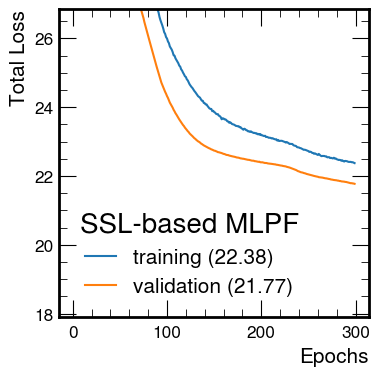

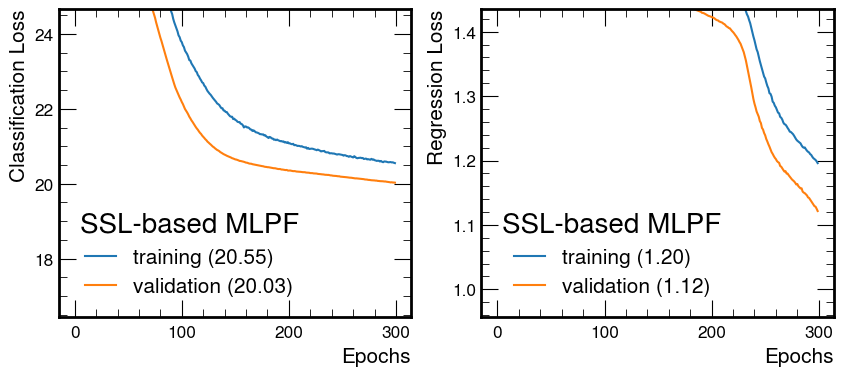

In [30]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

losses_to_plot["ssl"]["tot"] = losses_valid_tot
losses_to_plot["ssl"]["id"] = losses_valid_id
losses_to_plot["ssl"]["p4"] = losses_valid_momentum

In [56]:
with open(f"/pfclicvol/losses_to_plot.pkl", "wb") as f:  # dump model architecture
    pkl.dump(losses_to_plot, f, protocol=pkl.HIGHEST_PROTOCOL)

# Native

In [8]:
with open(f"/pfclicvol/losses_to_plot.pkl", "rb") as f:
    losses_to_plot = pkl.load(f)

In [31]:
ssl = 0

mlpf_model_kwargs = {
    "input_dim": input_,
    "width": 256,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": ssl,
    "VICReg_embedding_dim": embedding_dim_VICReg
}

mlpf = MLPF(**mlpf_model_kwargs).to(device)
print(mlpf)

if ssl:
    mode = "ssl"
else:
    mode = "native"

MLPF(
  (nn_id): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (15): Dropout(p=0.4, inplace=False)
    (16): Linear(in_features=256, out_features=256, bias=True)
    (17): ELU(alpha=1.0)
    (18): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (19): Linear(in_features=256, out_features=6, bias=True)
 

In [32]:
n_epochs = 300
lr = 5e-5
patience = 50
FineTune_VICReg=False

# make mlpf specific directory
print(f"- Training {mode} MLPF over {n_epochs} epochs")

t0_initial = time.time()

losses_train_tot, losses_train_id, losses_train_momentum = [], [], []
losses_valid_tot, losses_valid_id, losses_valid_momentum = [], [], []

best_val_loss_tot, best_val_loss_id, best_val_loss_momentum = 99999.9, 99999.9, 99999.9
stale_epochs = 0

optimizer = torch.optim.AdamW(mlpf.parameters(), lr=lr)
if FineTune_VICReg:
    print("Will finetune VICReg during mlpf training")
    optimizer_VICReg = torch.optim.SGD(encoder.parameters(), lr=lr * 0.1)
else:
    print("Will fix VICReg during mlpf training")
    optimizer_VICReg = None

# set VICReg to evaluation mode
encoder.eval()

for epoch in range(n_epochs):
    t0 = time.time()

    if stale_epochs > patience:
        print("breaking due to stale epochs")
        break

    # training step
    losses_t_tot, losses_t_id, losses_t_momentum = train(
        device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode
    )
    losses_train_tot.append(losses_t_tot)
    losses_train_id.append(losses_t_id)
    losses_train_momentum.append(losses_t_momentum)

    # validation step
    losses_v_tot, losses_v_id, losses_v_momentum = validation_run(
        device, encoder, mlpf, train_loader, valid_loader, mode
    )
    losses_valid_tot.append(losses_v_tot)
    losses_valid_id.append(losses_v_id)
    losses_valid_momentum.append(losses_v_momentum)

    if losses_v_id < best_val_loss_id:
        best_val_loss_id = losses_v_id
        best_train_loss_id = losses_t_id

    if losses_v_momentum < best_val_loss_momentum:
        best_val_loss_momentum = losses_v_momentum
        best_train_loss_momentum = losses_t_momentum

    # early-stopping
    if losses_v_tot < best_val_loss_tot:
        best_val_loss_tot = losses_v_tot
        best_train_loss_tot = losses_t_tot

        stale_epochs = 0
    else:
        stale_epochs += 1

    t1 = time.time()

    epochs_remaining = n_epochs - (epoch + 1)
    time_per_epoch = (t1 - t0_initial) / (epoch + 1)
    eta = epochs_remaining * time_per_epoch / 60

    print(
        f"epoch={epoch + 1} / {n_epochs} "
        + f"train_loss={round(losses_train_tot[epoch], 4)} "
        + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
        + f"stale={stale_epochs} "
        + f"time={round((t1-t0)/60, 2)}m "
        + f"eta={round(eta, 1)}m"
    )

    print("----------------------------------------------------------")
print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

- Training native MLPF over 300 epochs
Will fix VICReg during mlpf training
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=116.89 loss_momentum=2.56 loss_charge=1.07
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]


loss_id=74.97 loss_momentum=1.80 loss_charge=0.81
epoch=1 / 300 train_loss=120.5226 valid_loss=77.5769 stale=0 time=0.13m eta=39.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=84.47 loss_momentum=2.20 loss_charge=0.91
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


loss_id=54.15 loss_momentum=1.77 loss_charge=0.66
epoch=2 / 300 train_loss=87.5709 valid_loss=56.5828 stale=0 time=0.14m eta=40.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=66.55 loss_momentum=2.03 loss_charge=0.79
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]


loss_id=44.31 loss_momentum=1.75 loss_charge=0.63
epoch=3 / 300 train_loss=69.3728 valid_loss=46.6947 stale=0 time=0.14m eta=40.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=54.02 loss_momentum=1.95 loss_charge=0.72
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


loss_id=42.50 loss_momentum=1.74 loss_charge=0.63
epoch=4 / 300 train_loss=56.6932 valid_loss=44.8734 stale=0 time=0.14m eta=40.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.83it/s]


loss_id=46.33 loss_momentum=1.90 loss_charge=0.68
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]


loss_id=42.15 loss_momentum=1.74 loss_charge=0.63
epoch=5 / 300 train_loss=48.9215 valid_loss=44.5292 stale=0 time=0.13m eta=39.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.58it/s]


loss_id=41.96 loss_momentum=1.87 loss_charge=0.67
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]


loss_id=40.15 loss_momentum=1.74 loss_charge=0.63
epoch=6 / 300 train_loss=44.4984 valid_loss=42.5231 stale=0 time=0.14m eta=40.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=39.25 loss_momentum=1.86 loss_charge=0.66
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.43it/s]


loss_id=37.30 loss_momentum=1.74 loss_charge=0.63
epoch=7 / 300 train_loss=41.7638 valid_loss=39.669 stale=0 time=0.14m eta=39.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=37.24 loss_momentum=1.84 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s]


loss_id=35.00 loss_momentum=1.74 loss_charge=0.63
epoch=8 / 300 train_loss=39.7294 valid_loss=37.3692 stale=0 time=0.13m eta=39.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.81it/s]


loss_id=35.86 loss_momentum=1.83 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


loss_id=33.60 loss_momentum=1.73 loss_charge=0.63
epoch=9 / 300 train_loss=38.3409 valid_loss=35.9631 stale=0 time=0.13m eta=39.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.57it/s]


loss_id=34.83 loss_momentum=1.83 loss_charge=0.65
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=32.75 loss_momentum=1.73 loss_charge=0.63
epoch=10 / 300 train_loss=37.2996 valid_loss=35.1157 stale=0 time=0.15m eta=39.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=33.99 loss_momentum=1.82 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


loss_id=32.06 loss_momentum=1.73 loss_charge=0.63
epoch=11 / 300 train_loss=36.4526 valid_loss=34.4239 stale=0 time=0.13m eta=39.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=33.39 loss_momentum=1.82 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]


loss_id=31.40 loss_momentum=1.73 loss_charge=0.63
epoch=12 / 300 train_loss=35.8495 valid_loss=33.7613 stale=0 time=0.13m eta=38.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s]


loss_id=32.82 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


loss_id=30.86 loss_momentum=1.73 loss_charge=0.63
epoch=13 / 300 train_loss=35.268 valid_loss=33.2201 stale=0 time=0.14m eta=38.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=32.34 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


loss_id=30.42 loss_momentum=1.73 loss_charge=0.63
epoch=14 / 300 train_loss=34.7888 valid_loss=32.7769 stale=0 time=0.13m eta=38.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


loss_id=31.96 loss_momentum=1.81 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.90it/s]


loss_id=30.09 loss_momentum=1.73 loss_charge=0.63
epoch=15 / 300 train_loss=34.4042 valid_loss=32.4391 stale=0 time=0.14m eta=38.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=31.61 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


loss_id=29.74 loss_momentum=1.72 loss_charge=0.63
epoch=16 / 300 train_loss=34.0503 valid_loss=32.0866 stale=0 time=0.14m eta=38.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=31.28 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.13it/s]


loss_id=29.48 loss_momentum=1.72 loss_charge=0.63
epoch=17 / 300 train_loss=33.7206 valid_loss=31.8254 stale=0 time=0.14m eta=38.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=31.01 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


loss_id=29.26 loss_momentum=1.72 loss_charge=0.63
epoch=18 / 300 train_loss=33.4507 valid_loss=31.6092 stale=0 time=0.14m eta=38.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.87it/s]


loss_id=30.79 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


loss_id=29.05 loss_momentum=1.72 loss_charge=0.63
epoch=19 / 300 train_loss=33.2234 valid_loss=31.3981 stale=0 time=0.12m eta=38.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=30.56 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


loss_id=28.87 loss_momentum=1.72 loss_charge=0.63
epoch=20 / 300 train_loss=32.9966 valid_loss=31.2166 stale=0 time=0.14m eta=37.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=30.34 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]


loss_id=28.74 loss_momentum=1.72 loss_charge=0.63
epoch=21 / 300 train_loss=32.7747 valid_loss=31.0842 stale=0 time=0.14m eta=37.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.83it/s]


loss_id=30.17 loss_momentum=1.80 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


loss_id=28.61 loss_momentum=1.71 loss_charge=0.63
epoch=22 / 300 train_loss=32.6019 valid_loss=30.9562 stale=0 time=0.13m eta=37.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=30.01 loss_momentum=1.79 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]


loss_id=28.50 loss_momentum=1.71 loss_charge=0.63
epoch=23 / 300 train_loss=32.4388 valid_loss=30.8405 stale=0 time=0.14m eta=37.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=29.87 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.11it/s]


loss_id=28.41 loss_momentum=1.71 loss_charge=0.63
epoch=24 / 300 train_loss=32.2988 valid_loss=30.7497 stale=0 time=0.13m eta=37.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s]


loss_id=29.74 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.54it/s]


loss_id=28.35 loss_momentum=1.71 loss_charge=0.63
epoch=25 / 300 train_loss=32.1666 valid_loss=30.6807 stale=0 time=0.14m eta=37.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.86it/s]


loss_id=29.58 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s]


loss_id=28.26 loss_momentum=1.71 loss_charge=0.63
epoch=26 / 300 train_loss=32.0051 valid_loss=30.5905 stale=0 time=0.12m eta=36.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=29.49 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]


loss_id=28.20 loss_momentum=1.70 loss_charge=0.63
epoch=27 / 300 train_loss=31.9145 valid_loss=30.5355 stale=0 time=0.14m eta=36.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.50it/s]


loss_id=29.38 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]


loss_id=28.13 loss_momentum=1.70 loss_charge=0.63
epoch=28 / 300 train_loss=31.8012 valid_loss=30.454 stale=0 time=0.15m eta=36.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=29.25 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


loss_id=28.08 loss_momentum=1.70 loss_charge=0.63
epoch=29 / 300 train_loss=31.6752 valid_loss=30.4063 stale=0 time=0.14m eta=36.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.84it/s]


loss_id=29.16 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.20it/s]


loss_id=28.04 loss_momentum=1.70 loss_charge=0.63
epoch=30 / 300 train_loss=31.5814 valid_loss=30.3619 stale=0 time=0.13m eta=36.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=29.09 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]


loss_id=27.98 loss_momentum=1.69 loss_charge=0.63
epoch=31 / 300 train_loss=31.5064 valid_loss=30.3034 stale=0 time=0.14m eta=36.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.82it/s]


loss_id=29.01 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=27.96 loss_momentum=1.69 loss_charge=0.63
epoch=32 / 300 train_loss=31.4307 valid_loss=30.2749 stale=0 time=0.13m eta=36.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=28.93 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]


loss_id=27.91 loss_momentum=1.69 loss_charge=0.63
epoch=33 / 300 train_loss=31.3424 valid_loss=30.2267 stale=0 time=0.13m eta=36.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=28.86 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


loss_id=27.88 loss_momentum=1.69 loss_charge=0.63
epoch=34 / 300 train_loss=31.2689 valid_loss=30.1895 stale=0 time=0.13m eta=36.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=28.81 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]


loss_id=27.81 loss_momentum=1.68 loss_charge=0.63
epoch=35 / 300 train_loss=31.2236 valid_loss=30.123 stale=0 time=0.14m eta=35.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.81it/s]


loss_id=28.74 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


loss_id=27.79 loss_momentum=1.68 loss_charge=0.63
epoch=36 / 300 train_loss=31.1495 valid_loss=30.0957 stale=0 time=0.13m eta=35.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=28.67 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=27.77 loss_momentum=1.68 loss_charge=0.63
epoch=37 / 300 train_loss=31.0781 valid_loss=30.0713 stale=0 time=0.14m eta=35.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=28.62 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]


loss_id=27.72 loss_momentum=1.68 loss_charge=0.63
epoch=38 / 300 train_loss=31.0285 valid_loss=30.0227 stale=0 time=0.13m eta=35.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.82it/s]


loss_id=28.57 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=27.69 loss_momentum=1.67 loss_charge=0.63
epoch=39 / 300 train_loss=30.9716 valid_loss=29.9874 stale=0 time=0.13m eta=35.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=28.48 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.32it/s]


loss_id=27.66 loss_momentum=1.67 loss_charge=0.63
epoch=40 / 300 train_loss=30.8828 valid_loss=29.955 stale=0 time=0.14m eta=35.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.85it/s]


loss_id=28.45 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=27.63 loss_momentum=1.67 loss_charge=0.63
epoch=41 / 300 train_loss=30.8546 valid_loss=29.9209 stale=0 time=0.12m eta=34.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=28.41 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=27.60 loss_momentum=1.66 loss_charge=0.63
epoch=42 / 300 train_loss=30.8056 valid_loss=29.8886 stale=0 time=0.14m eta=34.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.45it/s]


loss_id=28.36 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]


loss_id=27.57 loss_momentum=1.66 loss_charge=0.63
epoch=43 / 300 train_loss=30.751 valid_loss=29.8611 stale=0 time=0.16m eta=34.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=28.32 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.90it/s]


loss_id=27.55 loss_momentum=1.66 loss_charge=0.63
epoch=44 / 300 train_loss=30.7094 valid_loss=29.8382 stale=0 time=0.13m eta=34.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=28.27 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


loss_id=27.50 loss_momentum=1.66 loss_charge=0.63
epoch=45 / 300 train_loss=30.6636 valid_loss=29.7786 stale=0 time=0.13m eta=34.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=28.23 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


loss_id=27.48 loss_momentum=1.65 loss_charge=0.63
epoch=46 / 300 train_loss=30.6195 valid_loss=29.7607 stale=0 time=0.13m eta=34.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=28.19 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


loss_id=27.45 loss_momentum=1.65 loss_charge=0.63
epoch=47 / 300 train_loss=30.5752 valid_loss=29.7274 stale=0 time=0.13m eta=34.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=28.16 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


loss_id=27.43 loss_momentum=1.65 loss_charge=0.63
epoch=48 / 300 train_loss=30.5436 valid_loss=29.7019 stale=0 time=0.13m eta=34.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=28.13 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


loss_id=27.39 loss_momentum=1.64 loss_charge=0.63
epoch=49 / 300 train_loss=30.5144 valid_loss=29.6639 stale=0 time=0.13m eta=33.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=28.10 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=27.37 loss_momentum=1.64 loss_charge=0.63
epoch=50 / 300 train_loss=30.4773 valid_loss=29.6362 stale=0 time=0.13m eta=33.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=28.05 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


loss_id=27.34 loss_momentum=1.64 loss_charge=0.63
epoch=51 / 300 train_loss=30.4244 valid_loss=29.6052 stale=0 time=0.14m eta=33.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=28.02 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]


loss_id=27.31 loss_momentum=1.64 loss_charge=0.63
epoch=52 / 300 train_loss=30.388 valid_loss=29.5743 stale=0 time=0.13m eta=33.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.77it/s]


loss_id=27.97 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.07it/s]


loss_id=27.28 loss_momentum=1.63 loss_charge=0.63
epoch=53 / 300 train_loss=30.34 valid_loss=29.5401 stale=0 time=0.13m eta=33.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=27.96 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.09it/s]


loss_id=27.24 loss_momentum=1.63 loss_charge=0.63
epoch=54 / 300 train_loss=30.322 valid_loss=29.4999 stale=0 time=0.13m eta=33.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=27.91 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.96it/s]


loss_id=27.21 loss_momentum=1.63 loss_charge=0.63
epoch=55 / 300 train_loss=30.2714 valid_loss=29.4673 stale=0 time=0.13m eta=33.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.79it/s]


loss_id=27.89 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]


loss_id=27.19 loss_momentum=1.62 loss_charge=0.63
epoch=56 / 300 train_loss=30.2493 valid_loss=29.4384 stale=0 time=0.13m eta=32.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=27.87 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


loss_id=27.15 loss_momentum=1.62 loss_charge=0.63
epoch=57 / 300 train_loss=30.2231 valid_loss=29.3928 stale=0 time=0.14m eta=32.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=27.80 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]


loss_id=27.12 loss_momentum=1.62 loss_charge=0.63
epoch=58 / 300 train_loss=30.1554 valid_loss=29.3686 stale=0 time=0.13m eta=32.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=27.80 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


loss_id=27.09 loss_momentum=1.61 loss_charge=0.63
epoch=59 / 300 train_loss=30.1509 valid_loss=29.3313 stale=0 time=0.13m eta=32.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.92it/s]


loss_id=27.75 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s]


loss_id=27.06 loss_momentum=1.61 loss_charge=0.63
epoch=60 / 300 train_loss=30.1022 valid_loss=29.2932 stale=0 time=0.12m eta=32.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=27.72 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


loss_id=27.03 loss_momentum=1.61 loss_charge=0.63
epoch=61 / 300 train_loss=30.0684 valid_loss=29.265 stale=0 time=0.14m eta=32.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=27.69 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


loss_id=27.00 loss_momentum=1.61 loss_charge=0.63
epoch=62 / 300 train_loss=30.0268 valid_loss=29.2343 stale=0 time=0.13m eta=32.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.83it/s]


loss_id=27.67 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s]


loss_id=26.98 loss_momentum=1.60 loss_charge=0.63
epoch=63 / 300 train_loss=30.0087 valid_loss=29.2083 stale=0 time=0.13m eta=31.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=27.67 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=26.95 loss_momentum=1.60 loss_charge=0.63
epoch=64 / 300 train_loss=30.0047 valid_loss=29.1739 stale=0 time=0.13m eta=31.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=27.62 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=26.92 loss_momentum=1.60 loss_charge=0.63
epoch=65 / 300 train_loss=29.9581 valid_loss=29.1376 stale=0 time=0.13m eta=31.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.77it/s]


loss_id=27.58 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


loss_id=26.88 loss_momentum=1.59 loss_charge=0.63
epoch=66 / 300 train_loss=29.9142 valid_loss=29.0965 stale=0 time=0.13m eta=31.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=27.57 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


loss_id=26.84 loss_momentum=1.59 loss_charge=0.63
epoch=67 / 300 train_loss=29.8986 valid_loss=29.056 stale=0 time=0.14m eta=31.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=27.53 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.14it/s]


loss_id=26.81 loss_momentum=1.59 loss_charge=0.63
epoch=68 / 300 train_loss=29.8588 valid_loss=29.023 stale=0 time=0.13m eta=31.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=27.53 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=26.77 loss_momentum=1.58 loss_charge=0.63
epoch=69 / 300 train_loss=29.8501 valid_loss=28.983 stale=0 time=0.14m eta=31.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=27.48 loss_momentum=1.69 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s]


loss_id=26.75 loss_momentum=1.58 loss_charge=0.63
epoch=70 / 300 train_loss=29.7962 valid_loss=28.9534 stale=0 time=0.14m eta=30.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.56it/s]


loss_id=27.45 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


loss_id=26.72 loss_momentum=1.58 loss_charge=0.63
epoch=71 / 300 train_loss=29.7676 valid_loss=28.9223 stale=0 time=0.15m eta=30.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


loss_id=27.43 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


loss_id=26.67 loss_momentum=1.58 loss_charge=0.63
epoch=72 / 300 train_loss=29.7473 valid_loss=28.8766 stale=0 time=0.14m eta=30.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]


loss_id=27.41 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.37it/s]


loss_id=26.65 loss_momentum=1.58 loss_charge=0.63
epoch=73 / 300 train_loss=29.7179 valid_loss=28.8461 stale=0 time=0.14m eta=30.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=27.40 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.34it/s]


loss_id=26.61 loss_momentum=1.57 loss_charge=0.63
epoch=74 / 300 train_loss=29.7028 valid_loss=28.8107 stale=0 time=0.14m eta=30.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.57it/s]


loss_id=27.35 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.09it/s]


loss_id=26.57 loss_momentum=1.57 loss_charge=0.63
epoch=75 / 300 train_loss=29.6527 valid_loss=28.7687 stale=0 time=0.14m eta=30.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=27.36 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.19it/s]


loss_id=26.54 loss_momentum=1.57 loss_charge=0.63
epoch=76 / 300 train_loss=29.6586 valid_loss=28.7346 stale=0 time=0.13m eta=30.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]


loss_id=27.31 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]


loss_id=26.51 loss_momentum=1.57 loss_charge=0.63
epoch=77 / 300 train_loss=29.609 valid_loss=28.7016 stale=0 time=0.14m eta=30.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=27.30 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]


loss_id=26.47 loss_momentum=1.57 loss_charge=0.63
epoch=78 / 300 train_loss=29.5976 valid_loss=28.6633 stale=0 time=0.13m eta=29.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s]


loss_id=27.26 loss_momentum=1.67 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


loss_id=26.44 loss_momentum=1.56 loss_charge=0.63
epoch=79 / 300 train_loss=29.5539 valid_loss=28.6283 stale=0 time=0.14m eta=29.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.87it/s]


loss_id=27.24 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=26.40 loss_momentum=1.56 loss_charge=0.63
epoch=80 / 300 train_loss=29.5292 valid_loss=28.5905 stale=0 time=0.12m eta=29.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=27.21 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]


loss_id=26.37 loss_momentum=1.56 loss_charge=0.63
epoch=81 / 300 train_loss=29.506 valid_loss=28.5528 stale=0 time=0.13m eta=29.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=27.18 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


loss_id=26.32 loss_momentum=1.56 loss_charge=0.63
epoch=82 / 300 train_loss=29.4672 valid_loss=28.5064 stale=0 time=0.14m eta=29.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=27.19 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s]


loss_id=26.28 loss_momentum=1.56 loss_charge=0.63
epoch=83 / 300 train_loss=29.4756 valid_loss=28.4699 stale=0 time=0.14m eta=29.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=27.11 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=26.24 loss_momentum=1.56 loss_charge=0.63
epoch=84 / 300 train_loss=29.3989 valid_loss=28.4264 stale=0 time=0.14m eta=29.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=27.13 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


loss_id=26.21 loss_momentum=1.56 loss_charge=0.63
epoch=85 / 300 train_loss=29.4188 valid_loss=28.3915 stale=0 time=0.13m eta=29.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=27.08 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=26.18 loss_momentum=1.56 loss_charge=0.63
epoch=86 / 300 train_loss=29.3644 valid_loss=28.3581 stale=0 time=0.14m eta=28.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.82it/s]


loss_id=27.08 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]


loss_id=26.12 loss_momentum=1.56 loss_charge=0.63
epoch=87 / 300 train_loss=29.3611 valid_loss=28.3039 stale=0 time=0.13m eta=28.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=27.03 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]


loss_id=26.10 loss_momentum=1.55 loss_charge=0.63
epoch=88 / 300 train_loss=29.3147 valid_loss=28.2775 stale=0 time=0.14m eta=28.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]


loss_id=27.01 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.18it/s]


loss_id=26.05 loss_momentum=1.55 loss_charge=0.63
epoch=89 / 300 train_loss=29.2893 valid_loss=28.2343 stale=0 time=0.14m eta=28.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=26.99 loss_momentum=1.65 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]


loss_id=26.00 loss_momentum=1.55 loss_charge=0.63
epoch=90 / 300 train_loss=29.2704 valid_loss=28.18 stale=0 time=0.14m eta=28.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=26.99 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


loss_id=25.96 loss_momentum=1.55 loss_charge=0.63
epoch=91 / 300 train_loss=29.2692 valid_loss=28.1414 stale=0 time=0.13m eta=28.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=26.95 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.31it/s]


loss_id=25.92 loss_momentum=1.55 loss_charge=0.63
epoch=92 / 300 train_loss=29.2294 valid_loss=28.0998 stale=0 time=0.14m eta=28.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=26.95 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s]


loss_id=25.90 loss_momentum=1.55 loss_charge=0.63
epoch=93 / 300 train_loss=29.2231 valid_loss=28.0734 stale=0 time=0.13m eta=27.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=26.88 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


loss_id=25.86 loss_momentum=1.55 loss_charge=0.63
epoch=94 / 300 train_loss=29.1482 valid_loss=28.036 stale=0 time=0.13m eta=27.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=26.88 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


loss_id=25.81 loss_momentum=1.55 loss_charge=0.63
epoch=95 / 300 train_loss=29.152 valid_loss=27.9895 stale=0 time=0.13m eta=27.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


loss_id=26.82 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=25.77 loss_momentum=1.55 loss_charge=0.63
epoch=96 / 300 train_loss=29.0917 valid_loss=27.947 stale=0 time=0.13m eta=27.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=26.82 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]


loss_id=25.72 loss_momentum=1.55 loss_charge=0.63
epoch=97 / 300 train_loss=29.0851 valid_loss=27.8954 stale=0 time=0.14m eta=27.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.56it/s]


loss_id=26.79 loss_momentum=1.64 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


loss_id=25.68 loss_momentum=1.55 loss_charge=0.63
epoch=98 / 300 train_loss=29.0554 valid_loss=27.8547 stale=0 time=0.15m eta=27.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.81it/s]


loss_id=26.77 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]


loss_id=25.65 loss_momentum=1.55 loss_charge=0.63
epoch=99 / 300 train_loss=29.0323 valid_loss=27.8196 stale=0 time=0.13m eta=27.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


loss_id=26.72 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


loss_id=25.59 loss_momentum=1.55 loss_charge=0.63
epoch=100 / 300 train_loss=28.9859 valid_loss=27.7635 stale=0 time=0.13m eta=27.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s]


loss_id=26.69 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


loss_id=25.55 loss_momentum=1.55 loss_charge=0.63
epoch=101 / 300 train_loss=28.9486 valid_loss=27.7198 stale=0 time=0.15m eta=26.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=26.68 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=25.51 loss_momentum=1.55 loss_charge=0.63
epoch=102 / 300 train_loss=28.9448 valid_loss=27.6787 stale=0 time=0.13m eta=26.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=26.66 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


loss_id=25.47 loss_momentum=1.55 loss_charge=0.63
epoch=103 / 300 train_loss=28.9246 valid_loss=27.6417 stale=0 time=0.13m eta=26.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=26.66 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s]


loss_id=25.44 loss_momentum=1.55 loss_charge=0.63
epoch=104 / 300 train_loss=28.9254 valid_loss=27.61 stale=0 time=0.14m eta=26.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=26.63 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]


loss_id=25.40 loss_momentum=1.55 loss_charge=0.63
epoch=105 / 300 train_loss=28.8887 valid_loss=27.5693 stale=0 time=0.14m eta=26.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]


loss_id=26.62 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


loss_id=25.35 loss_momentum=1.55 loss_charge=0.63
epoch=106 / 300 train_loss=28.878 valid_loss=27.5236 stale=0 time=0.14m eta=26.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=26.56 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]


loss_id=25.31 loss_momentum=1.55 loss_charge=0.63
epoch=107 / 300 train_loss=28.8194 valid_loss=27.4833 stale=0 time=0.13m eta=26.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.81it/s]


loss_id=26.53 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=25.27 loss_momentum=1.54 loss_charge=0.63
epoch=108 / 300 train_loss=28.7857 valid_loss=27.4379 stale=0 time=0.13m eta=25.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


loss_id=26.51 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]


loss_id=25.22 loss_momentum=1.54 loss_charge=0.63
epoch=109 / 300 train_loss=28.7645 valid_loss=27.3853 stale=0 time=0.14m eta=25.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=26.51 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


loss_id=25.18 loss_momentum=1.54 loss_charge=0.63
epoch=110 / 300 train_loss=28.7663 valid_loss=27.349 stale=0 time=0.13m eta=25.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=26.47 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]


loss_id=25.13 loss_momentum=1.54 loss_charge=0.63
epoch=111 / 300 train_loss=28.719 valid_loss=27.301 stale=0 time=0.14m eta=25.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.82it/s]


loss_id=26.47 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


loss_id=25.09 loss_momentum=1.54 loss_charge=0.63
epoch=112 / 300 train_loss=28.7205 valid_loss=27.2572 stale=0 time=0.13m eta=25.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=26.40 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


loss_id=25.07 loss_momentum=1.54 loss_charge=0.63
epoch=113 / 300 train_loss=28.6539 valid_loss=27.2361 stale=0 time=0.14m eta=25.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=26.39 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


loss_id=25.02 loss_momentum=1.54 loss_charge=0.63
epoch=114 / 300 train_loss=28.6386 valid_loss=27.1923 stale=0 time=0.14m eta=25.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=26.37 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]


loss_id=24.97 loss_momentum=1.54 loss_charge=0.63
epoch=115 / 300 train_loss=28.6215 valid_loss=27.1417 stale=0 time=0.14m eta=25.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


loss_id=26.37 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s]


loss_id=24.93 loss_momentum=1.54 loss_charge=0.63
epoch=116 / 300 train_loss=28.6174 valid_loss=27.0946 stale=0 time=0.13m eta=24.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=26.35 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=24.89 loss_momentum=1.54 loss_charge=0.63
epoch=117 / 300 train_loss=28.5993 valid_loss=27.0529 stale=0 time=0.13m eta=24.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.89it/s]


loss_id=26.28 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]


loss_id=24.85 loss_momentum=1.54 loss_charge=0.63
epoch=118 / 300 train_loss=28.5299 valid_loss=27.021 stale=0 time=0.12m eta=24.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=26.28 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.53it/s]


loss_id=24.81 loss_momentum=1.54 loss_charge=0.63
epoch=119 / 300 train_loss=28.5252 valid_loss=26.9789 stale=0 time=0.14m eta=24.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=26.23 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=24.77 loss_momentum=1.54 loss_charge=0.63
epoch=120 / 300 train_loss=28.4755 valid_loss=26.9345 stale=0 time=0.14m eta=24.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  2.04it/s]


loss_id=26.23 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


loss_id=24.73 loss_momentum=1.54 loss_charge=0.63
epoch=121 / 300 train_loss=28.4757 valid_loss=26.8961 stale=0 time=0.11m eta=24.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=26.19 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]


loss_id=24.69 loss_momentum=1.54 loss_charge=0.63
epoch=122 / 300 train_loss=28.4366 valid_loss=26.8505 stale=0 time=0.14m eta=24.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=26.18 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


loss_id=24.64 loss_momentum=1.54 loss_charge=0.63
epoch=123 / 300 train_loss=28.4273 valid_loss=26.8054 stale=0 time=0.13m eta=23.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=26.15 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.15it/s]


loss_id=24.61 loss_momentum=1.54 loss_charge=0.63
epoch=124 / 300 train_loss=28.3989 valid_loss=26.776 stale=0 time=0.14m eta=23.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=26.10 loss_momentum=1.62 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


loss_id=24.57 loss_momentum=1.54 loss_charge=0.63
epoch=125 / 300 train_loss=28.349 valid_loss=26.7291 stale=0 time=0.14m eta=23.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=26.07 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s]


loss_id=24.51 loss_momentum=1.54 loss_charge=0.63
epoch=126 / 300 train_loss=28.311 valid_loss=26.6773 stale=0 time=0.13m eta=23.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=26.04 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=24.49 loss_momentum=1.54 loss_charge=0.63
epoch=127 / 300 train_loss=28.2806 valid_loss=26.65 stale=0 time=0.14m eta=23.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=26.05 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


loss_id=24.43 loss_momentum=1.54 loss_charge=0.63
epoch=128 / 300 train_loss=28.2944 valid_loss=26.5962 stale=0 time=0.14m eta=23.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=26.01 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


loss_id=24.40 loss_momentum=1.54 loss_charge=0.63
epoch=129 / 300 train_loss=28.2476 valid_loss=26.5645 stale=0 time=0.14m eta=23.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=25.99 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


loss_id=24.36 loss_momentum=1.54 loss_charge=0.63
epoch=130 / 300 train_loss=28.2283 valid_loss=26.5265 stale=0 time=0.14m eta=22.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]


loss_id=26.00 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.48it/s]


loss_id=24.34 loss_momentum=1.54 loss_charge=0.63
epoch=131 / 300 train_loss=28.2419 valid_loss=26.499 stale=0 time=0.14m eta=22.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=25.93 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


loss_id=24.29 loss_momentum=1.54 loss_charge=0.63
epoch=132 / 300 train_loss=28.1735 valid_loss=26.4542 stale=0 time=0.13m eta=22.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=25.87 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s]


loss_id=24.25 loss_momentum=1.54 loss_charge=0.63
epoch=133 / 300 train_loss=28.1076 valid_loss=26.4129 stale=0 time=0.13m eta=22.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=25.88 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


loss_id=24.21 loss_momentum=1.54 loss_charge=0.63
epoch=134 / 300 train_loss=28.1148 valid_loss=26.3669 stale=0 time=0.13m eta=22.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]


loss_id=25.83 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]


loss_id=24.17 loss_momentum=1.54 loss_charge=0.63
epoch=135 / 300 train_loss=28.0655 valid_loss=26.3275 stale=0 time=0.14m eta=22.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=25.79 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


loss_id=24.12 loss_momentum=1.54 loss_charge=0.63
epoch=136 / 300 train_loss=28.0326 valid_loss=26.2823 stale=0 time=0.14m eta=22.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.56it/s]


loss_id=25.78 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]


loss_id=24.09 loss_momentum=1.54 loss_charge=0.63
epoch=137 / 300 train_loss=28.0169 valid_loss=26.2552 stale=0 time=0.15m eta=22.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s]


loss_id=25.76 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=24.06 loss_momentum=1.54 loss_charge=0.63
epoch=138 / 300 train_loss=28.0011 valid_loss=26.2214 stale=0 time=0.14m eta=21.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=25.73 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]


loss_id=24.02 loss_momentum=1.54 loss_charge=0.63
epoch=139 / 300 train_loss=27.969 valid_loss=26.1804 stale=0 time=0.14m eta=21.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=25.71 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=24.00 loss_momentum=1.53 loss_charge=0.63
epoch=140 / 300 train_loss=27.947 valid_loss=26.157 stale=0 time=0.14m eta=21.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=25.69 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


loss_id=23.95 loss_momentum=1.53 loss_charge=0.62
epoch=141 / 300 train_loss=27.928 valid_loss=26.1055 stale=0 time=0.14m eta=21.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=25.66 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


loss_id=23.91 loss_momentum=1.53 loss_charge=0.63
epoch=142 / 300 train_loss=27.8981 valid_loss=26.0691 stale=0 time=0.14m eta=21.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=25.60 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


loss_id=23.88 loss_momentum=1.53 loss_charge=0.62
epoch=143 / 300 train_loss=27.8381 valid_loss=26.0364 stale=0 time=0.14m eta=21.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=25.57 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.64it/s]


loss_id=23.85 loss_momentum=1.53 loss_charge=0.62
epoch=144 / 300 train_loss=27.8067 valid_loss=26.004 stale=0 time=0.14m eta=21.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.58it/s]


loss_id=25.58 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.50it/s]


loss_id=23.80 loss_momentum=1.53 loss_charge=0.62
epoch=145 / 300 train_loss=27.8106 valid_loss=25.9618 stale=0 time=0.14m eta=21.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.84it/s]


loss_id=25.50 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]


loss_id=23.77 loss_momentum=1.53 loss_charge=0.62
epoch=146 / 300 train_loss=27.7314 valid_loss=25.9287 stale=0 time=0.12m eta=20.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


loss_id=25.51 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=23.74 loss_momentum=1.53 loss_charge=0.62
epoch=147 / 300 train_loss=27.7409 valid_loss=25.8927 stale=0 time=0.13m eta=20.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=25.49 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


loss_id=23.71 loss_momentum=1.53 loss_charge=0.62
epoch=148 / 300 train_loss=27.7195 valid_loss=25.8663 stale=0 time=0.14m eta=20.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=25.44 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.17it/s]


loss_id=23.67 loss_momentum=1.53 loss_charge=0.62
epoch=149 / 300 train_loss=27.6693 valid_loss=25.831 stale=0 time=0.14m eta=20.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=25.39 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


loss_id=23.64 loss_momentum=1.53 loss_charge=0.62
epoch=150 / 300 train_loss=27.6264 valid_loss=25.7941 stale=0 time=0.14m eta=20.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=25.38 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]


loss_id=23.60 loss_momentum=1.53 loss_charge=0.62
epoch=151 / 300 train_loss=27.6133 valid_loss=25.7554 stale=0 time=0.13m eta=20.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=25.35 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]


loss_id=23.57 loss_momentum=1.53 loss_charge=0.62
epoch=152 / 300 train_loss=27.582 valid_loss=25.725 stale=0 time=0.13m eta=20.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=25.34 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


loss_id=23.55 loss_momentum=1.53 loss_charge=0.62
epoch=153 / 300 train_loss=27.5729 valid_loss=25.7013 stale=0 time=0.14m eta=19.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=25.31 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.90it/s]


loss_id=23.50 loss_momentum=1.53 loss_charge=0.62
epoch=154 / 300 train_loss=27.5415 valid_loss=25.6592 stale=0 time=0.14m eta=19.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=25.27 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


loss_id=23.48 loss_momentum=1.53 loss_charge=0.62
epoch=155 / 300 train_loss=27.504 valid_loss=25.6376 stale=0 time=0.13m eta=19.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=25.25 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


loss_id=23.45 loss_momentum=1.53 loss_charge=0.62
epoch=156 / 300 train_loss=27.4825 valid_loss=25.6019 stale=0 time=0.14m eta=19.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=25.20 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


loss_id=23.41 loss_momentum=1.53 loss_charge=0.62
epoch=157 / 300 train_loss=27.4295 valid_loss=25.5667 stale=0 time=0.14m eta=19.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=25.17 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


loss_id=23.39 loss_momentum=1.53 loss_charge=0.62
epoch=158 / 300 train_loss=27.4009 valid_loss=25.5393 stale=0 time=0.14m eta=19.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=25.14 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.08it/s]


loss_id=23.35 loss_momentum=1.53 loss_charge=0.62
epoch=159 / 300 train_loss=27.363 valid_loss=25.5063 stale=0 time=0.14m eta=19.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=25.10 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


loss_id=23.34 loss_momentum=1.53 loss_charge=0.62
epoch=160 / 300 train_loss=27.3274 valid_loss=25.4933 stale=0 time=0.14m eta=19.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=25.08 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


loss_id=23.30 loss_momentum=1.53 loss_charge=0.62
epoch=161 / 300 train_loss=27.3118 valid_loss=25.4548 stale=0 time=0.14m eta=18.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=25.08 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=23.27 loss_momentum=1.53 loss_charge=0.62
epoch=162 / 300 train_loss=27.3073 valid_loss=25.4191 stale=0 time=0.13m eta=18.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=25.03 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


loss_id=23.23 loss_momentum=1.53 loss_charge=0.62
epoch=163 / 300 train_loss=27.253 valid_loss=25.3814 stale=0 time=0.13m eta=18.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.80it/s]


loss_id=25.01 loss_momentum=1.60 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.91it/s]


loss_id=23.22 loss_momentum=1.53 loss_charge=0.62
epoch=164 / 300 train_loss=27.234 valid_loss=25.3766 stale=0 time=0.13m eta=18.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=25.01 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]


loss_id=23.20 loss_momentum=1.53 loss_charge=0.62
epoch=165 / 300 train_loss=27.2305 valid_loss=25.3524 stale=0 time=0.13m eta=18.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


loss_id=24.97 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.56it/s]


loss_id=23.16 loss_momentum=1.53 loss_charge=0.62
epoch=166 / 300 train_loss=27.1912 valid_loss=25.3074 stale=0 time=0.13m eta=18.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=24.95 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.93it/s]


loss_id=23.15 loss_momentum=1.53 loss_charge=0.62
epoch=167 / 300 train_loss=27.1761 valid_loss=25.3018 stale=0 time=0.14m eta=18.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.81it/s]


loss_id=24.93 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


loss_id=23.13 loss_momentum=1.53 loss_charge=0.62
epoch=168 / 300 train_loss=27.1493 valid_loss=25.2795 stale=0 time=0.13m eta=17.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=24.88 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.27it/s]


loss_id=23.10 loss_momentum=1.52 loss_charge=0.62
epoch=169 / 300 train_loss=27.1008 valid_loss=25.2466 stale=0 time=0.13m eta=17.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=24.86 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=23.06 loss_momentum=1.52 loss_charge=0.62
epoch=170 / 300 train_loss=27.0832 valid_loss=25.2128 stale=0 time=0.13m eta=17.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=24.83 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]


loss_id=23.06 loss_momentum=1.52 loss_charge=0.62
epoch=171 / 300 train_loss=27.0566 valid_loss=25.2045 stale=0 time=0.14m eta=17.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.80it/s]


loss_id=24.83 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.03it/s]


loss_id=23.00 loss_momentum=1.52 loss_charge=0.62
epoch=172 / 300 train_loss=27.0507 valid_loss=25.1529 stale=0 time=0.13m eta=17.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=24.79 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=23.00 loss_momentum=1.52 loss_charge=0.62
epoch=173 / 300 train_loss=27.0146 valid_loss=25.1461 stale=0 time=0.14m eta=17.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=24.73 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]


loss_id=22.94 loss_momentum=1.52 loss_charge=0.62
epoch=174 / 300 train_loss=26.9505 valid_loss=25.0933 stale=0 time=0.14m eta=17.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.79it/s]


loss_id=24.74 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


loss_id=22.95 loss_momentum=1.52 loss_charge=0.62
epoch=175 / 300 train_loss=26.9571 valid_loss=25.0984 stale=1 time=0.13m eta=16.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.84it/s]


loss_id=24.69 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s]


loss_id=22.90 loss_momentum=1.52 loss_charge=0.62
epoch=176 / 300 train_loss=26.9115 valid_loss=25.0458 stale=0 time=0.13m eta=16.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=24.65 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]


loss_id=22.88 loss_momentum=1.52 loss_charge=0.62
epoch=177 / 300 train_loss=26.8743 valid_loss=25.0261 stale=0 time=0.13m eta=16.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=24.63 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=22.84 loss_momentum=1.52 loss_charge=0.62
epoch=178 / 300 train_loss=26.8473 valid_loss=24.9875 stale=0 time=0.13m eta=16.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=24.60 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.77it/s]


loss_id=22.82 loss_momentum=1.52 loss_charge=0.62
epoch=179 / 300 train_loss=26.8153 valid_loss=24.9617 stale=0 time=0.14m eta=16.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=24.56 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=22.78 loss_momentum=1.52 loss_charge=0.62
epoch=180 / 300 train_loss=26.7821 valid_loss=24.925 stale=0 time=0.14m eta=16.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.90it/s]


loss_id=24.58 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.27it/s]


loss_id=22.79 loss_momentum=1.52 loss_charge=0.62
epoch=181 / 300 train_loss=26.7973 valid_loss=24.9322 stale=1 time=0.12m eta=16.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=24.53 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.25it/s]


loss_id=22.74 loss_momentum=1.52 loss_charge=0.62
epoch=182 / 300 train_loss=26.7521 valid_loss=24.8886 stale=0 time=0.13m eta=15.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=24.54 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.76it/s]


loss_id=22.75 loss_momentum=1.52 loss_charge=0.62
epoch=183 / 300 train_loss=26.7523 valid_loss=24.8962 stale=1 time=0.13m eta=15.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=24.48 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]


loss_id=22.69 loss_momentum=1.52 loss_charge=0.62
epoch=184 / 300 train_loss=26.6973 valid_loss=24.833 stale=0 time=0.13m eta=15.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=24.45 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.98it/s]


loss_id=22.69 loss_momentum=1.52 loss_charge=0.62
epoch=185 / 300 train_loss=26.6696 valid_loss=24.8289 stale=0 time=0.14m eta=15.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=24.40 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=22.64 loss_momentum=1.52 loss_charge=0.62
epoch=186 / 300 train_loss=26.6149 valid_loss=24.7801 stale=0 time=0.13m eta=15.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=24.36 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.40it/s]


loss_id=22.61 loss_momentum=1.52 loss_charge=0.62
epoch=187 / 300 train_loss=26.5735 valid_loss=24.7541 stale=0 time=0.14m eta=15.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.83it/s]


loss_id=24.35 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


loss_id=22.59 loss_momentum=1.52 loss_charge=0.62
epoch=188 / 300 train_loss=26.5599 valid_loss=24.7312 stale=0 time=0.13m eta=15.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=24.34 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


loss_id=22.58 loss_momentum=1.52 loss_charge=0.62
epoch=189 / 300 train_loss=26.5505 valid_loss=24.7213 stale=0 time=0.14m eta=15.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=24.33 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


loss_id=22.53 loss_momentum=1.52 loss_charge=0.62
epoch=190 / 300 train_loss=26.542 valid_loss=24.6733 stale=0 time=0.14m eta=14.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=24.25 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


loss_id=22.51 loss_momentum=1.52 loss_charge=0.62
epoch=191 / 300 train_loss=26.465 valid_loss=24.6516 stale=0 time=0.13m eta=14.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=24.27 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]


loss_id=22.47 loss_momentum=1.51 loss_charge=0.62
epoch=192 / 300 train_loss=26.4809 valid_loss=24.6122 stale=0 time=0.14m eta=14.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=24.23 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]


loss_id=22.45 loss_momentum=1.51 loss_charge=0.62
epoch=193 / 300 train_loss=26.4394 valid_loss=24.5873 stale=0 time=0.14m eta=14.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=24.16 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]


loss_id=22.43 loss_momentum=1.51 loss_charge=0.62
epoch=194 / 300 train_loss=26.3722 valid_loss=24.5633 stale=0 time=0.13m eta=14.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=24.18 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=22.40 loss_momentum=1.51 loss_charge=0.62
epoch=195 / 300 train_loss=26.3909 valid_loss=24.5319 stale=0 time=0.13m eta=14.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=24.12 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.06it/s]


loss_id=22.37 loss_momentum=1.51 loss_charge=0.62
epoch=196 / 300 train_loss=26.3263 valid_loss=24.5031 stale=0 time=0.13m eta=14.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s]


loss_id=24.11 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


loss_id=22.35 loss_momentum=1.51 loss_charge=0.62
epoch=197 / 300 train_loss=26.3123 valid_loss=24.4799 stale=0 time=0.14m eta=13.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=24.06 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


loss_id=22.34 loss_momentum=1.51 loss_charge=0.62
epoch=198 / 300 train_loss=26.2672 valid_loss=24.4698 stale=0 time=0.13m eta=13.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


loss_id=24.04 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


loss_id=22.30 loss_momentum=1.51 loss_charge=0.62
epoch=199 / 300 train_loss=26.2467 valid_loss=24.4296 stale=0 time=0.14m eta=13.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.80it/s]


loss_id=24.01 loss_momentum=1.58 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


loss_id=22.29 loss_momentum=1.51 loss_charge=0.62
epoch=200 / 300 train_loss=26.2133 valid_loss=24.4157 stale=0 time=0.13m eta=13.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=23.97 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.25it/s]


loss_id=22.24 loss_momentum=1.51 loss_charge=0.62
epoch=201 / 300 train_loss=26.1759 valid_loss=24.3685 stale=0 time=0.14m eta=13.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=23.97 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]


loss_id=22.22 loss_momentum=1.50 loss_charge=0.62
epoch=202 / 300 train_loss=26.1689 valid_loss=24.3516 stale=0 time=0.14m eta=13.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=23.94 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


loss_id=22.20 loss_momentum=1.50 loss_charge=0.62
epoch=203 / 300 train_loss=26.1409 valid_loss=24.3293 stale=0 time=0.14m eta=13.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


loss_id=23.90 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]


loss_id=22.17 loss_momentum=1.50 loss_charge=0.62
epoch=204 / 300 train_loss=26.1014 valid_loss=24.3002 stale=0 time=0.14m eta=13.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=23.87 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.27it/s]


loss_id=22.16 loss_momentum=1.50 loss_charge=0.62
epoch=205 / 300 train_loss=26.0664 valid_loss=24.2868 stale=0 time=0.14m eta=12.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=23.87 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


loss_id=22.14 loss_momentum=1.50 loss_charge=0.62
epoch=206 / 300 train_loss=26.0671 valid_loss=24.2614 stale=0 time=0.13m eta=12.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=23.81 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.26it/s]


loss_id=22.10 loss_momentum=1.50 loss_charge=0.62
epoch=207 / 300 train_loss=26.0118 valid_loss=24.2183 stale=0 time=0.14m eta=12.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.88it/s]


loss_id=23.78 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.60it/s]


loss_id=22.09 loss_momentum=1.50 loss_charge=0.62
epoch=208 / 300 train_loss=25.9814 valid_loss=24.2083 stale=0 time=0.12m eta=12.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.84it/s]


loss_id=23.77 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


loss_id=22.06 loss_momentum=1.50 loss_charge=0.62
epoch=209 / 300 train_loss=25.9688 valid_loss=24.1768 stale=0 time=0.12m eta=12.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=23.72 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=22.03 loss_momentum=1.49 loss_charge=0.62
epoch=210 / 300 train_loss=25.9144 valid_loss=24.1509 stale=0 time=0.14m eta=12.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.79it/s]


loss_id=23.69 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


loss_id=22.01 loss_momentum=1.49 loss_charge=0.62
epoch=211 / 300 train_loss=25.8824 valid_loss=24.1301 stale=0 time=0.13m eta=12.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


loss_id=23.70 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


loss_id=21.99 loss_momentum=1.49 loss_charge=0.62
epoch=212 / 300 train_loss=25.8886 valid_loss=24.1051 stale=0 time=0.14m eta=11.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=23.69 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]


loss_id=21.97 loss_momentum=1.49 loss_charge=0.62
epoch=213 / 300 train_loss=25.8797 valid_loss=24.0879 stale=0 time=0.13m eta=11.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=23.63 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=21.94 loss_momentum=1.49 loss_charge=0.62
epoch=214 / 300 train_loss=25.818 valid_loss=24.0604 stale=0 time=0.14m eta=11.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.79it/s]


loss_id=23.61 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]


loss_id=21.91 loss_momentum=1.49 loss_charge=0.62
epoch=215 / 300 train_loss=25.8014 valid_loss=24.022 stale=0 time=0.13m eta=11.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=23.57 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]


loss_id=21.92 loss_momentum=1.49 loss_charge=0.62
epoch=216 / 300 train_loss=25.762 valid_loss=24.0315 stale=1 time=0.13m eta=11.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=23.58 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]


loss_id=21.90 loss_momentum=1.49 loss_charge=0.62
epoch=217 / 300 train_loss=25.7675 valid_loss=24.0087 stale=0 time=0.14m eta=11.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.89it/s]


loss_id=23.55 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


loss_id=21.87 loss_momentum=1.49 loss_charge=0.62
epoch=218 / 300 train_loss=25.7391 valid_loss=23.979 stale=0 time=0.12m eta=11.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=23.53 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=21.87 loss_momentum=1.49 loss_charge=0.62
epoch=219 / 300 train_loss=25.7141 valid_loss=23.9781 stale=0 time=0.13m eta=10.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=23.51 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.01it/s]


loss_id=21.83 loss_momentum=1.49 loss_charge=0.62
epoch=220 / 300 train_loss=25.6934 valid_loss=23.9429 stale=0 time=0.14m eta=10.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=23.47 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]


loss_id=21.81 loss_momentum=1.48 loss_charge=0.62
epoch=221 / 300 train_loss=25.6556 valid_loss=23.9213 stale=0 time=0.13m eta=10.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=23.43 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.87it/s]


loss_id=21.78 loss_momentum=1.48 loss_charge=0.62
epoch=222 / 300 train_loss=25.6213 valid_loss=23.8922 stale=0 time=0.13m eta=10.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=23.42 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


loss_id=21.79 loss_momentum=1.48 loss_charge=0.62
epoch=223 / 300 train_loss=25.6097 valid_loss=23.8964 stale=1 time=0.13m eta=10.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.51it/s]


loss_id=23.41 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.42it/s]


loss_id=21.76 loss_momentum=1.48 loss_charge=0.62
epoch=224 / 300 train_loss=25.5941 valid_loss=23.872 stale=0 time=0.15m eta=10.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=23.38 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]


loss_id=21.73 loss_momentum=1.48 loss_charge=0.62
epoch=225 / 300 train_loss=25.5621 valid_loss=23.8383 stale=0 time=0.14m eta=10.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=23.36 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.87it/s]


loss_id=21.72 loss_momentum=1.48 loss_charge=0.62
epoch=226 / 300 train_loss=25.5398 valid_loss=23.8308 stale=0 time=0.13m eta=10.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.89it/s]


loss_id=23.33 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]


loss_id=21.70 loss_momentum=1.48 loss_charge=0.62
epoch=227 / 300 train_loss=25.5183 valid_loss=23.8099 stale=0 time=0.12m eta=9.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=23.32 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=21.70 loss_momentum=1.48 loss_charge=0.62
epoch=228 / 300 train_loss=25.5087 valid_loss=23.8029 stale=0 time=0.14m eta=9.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=23.27 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


loss_id=21.65 loss_momentum=1.48 loss_charge=0.62
epoch=229 / 300 train_loss=25.4556 valid_loss=23.7595 stale=0 time=0.14m eta=9.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.54it/s]


loss_id=23.25 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


loss_id=21.67 loss_momentum=1.48 loss_charge=0.62
epoch=230 / 300 train_loss=25.4303 valid_loss=23.7743 stale=1 time=0.15m eta=9.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.81it/s]


loss_id=23.24 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.21it/s]


loss_id=21.64 loss_momentum=1.48 loss_charge=0.62
epoch=231 / 300 train_loss=25.4173 valid_loss=23.7418 stale=0 time=0.13m eta=9.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.84it/s]


loss_id=23.21 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]


loss_id=21.61 loss_momentum=1.48 loss_charge=0.62
epoch=232 / 300 train_loss=25.3939 valid_loss=23.7162 stale=0 time=0.12m eta=9.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=23.19 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=21.61 loss_momentum=1.48 loss_charge=0.62
epoch=233 / 300 train_loss=25.3721 valid_loss=23.716 stale=0 time=0.14m eta=9.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=23.17 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.83it/s]


loss_id=21.60 loss_momentum=1.48 loss_charge=0.62
epoch=234 / 300 train_loss=25.3541 valid_loss=23.6988 stale=0 time=0.13m eta=8.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=23.15 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


loss_id=21.56 loss_momentum=1.48 loss_charge=0.62
epoch=235 / 300 train_loss=25.334 valid_loss=23.6649 stale=0 time=0.14m eta=8.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=23.13 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.28it/s]


loss_id=21.57 loss_momentum=1.48 loss_charge=0.62
epoch=236 / 300 train_loss=25.3124 valid_loss=23.6711 stale=1 time=0.14m eta=8.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.73it/s]


loss_id=23.11 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]


loss_id=21.53 loss_momentum=1.48 loss_charge=0.62
epoch=237 / 300 train_loss=25.289 valid_loss=23.632 stale=0 time=0.13m eta=8.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=23.11 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=21.53 loss_momentum=1.48 loss_charge=0.62
epoch=238 / 300 train_loss=25.2826 valid_loss=23.6271 stale=0 time=0.13m eta=8.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=23.05 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.08it/s]


loss_id=21.51 loss_momentum=1.48 loss_charge=0.62
epoch=239 / 300 train_loss=25.2291 valid_loss=23.6096 stale=0 time=0.14m eta=8.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=23.07 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.62it/s]


loss_id=21.49 loss_momentum=1.47 loss_charge=0.62
epoch=240 / 300 train_loss=25.2452 valid_loss=23.5855 stale=0 time=0.14m eta=8.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=23.04 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.65it/s]


loss_id=21.47 loss_momentum=1.47 loss_charge=0.62
epoch=241 / 300 train_loss=25.2167 valid_loss=23.573 stale=0 time=0.13m eta=8.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=22.99 loss_momentum=1.55 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=21.45 loss_momentum=1.47 loss_charge=0.62
epoch=242 / 300 train_loss=25.1651 valid_loss=23.5459 stale=0 time=0.14m eta=7.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.74it/s]


loss_id=22.97 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


loss_id=21.43 loss_momentum=1.47 loss_charge=0.62
epoch=243 / 300 train_loss=25.1393 valid_loss=23.5276 stale=0 time=0.13m eta=7.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=22.96 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.68it/s]


loss_id=21.42 loss_momentum=1.47 loss_charge=0.62
epoch=244 / 300 train_loss=25.1356 valid_loss=23.5213 stale=0 time=0.14m eta=7.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.77it/s]


loss_id=22.94 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.57it/s]


loss_id=21.41 loss_momentum=1.47 loss_charge=0.62
epoch=245 / 300 train_loss=25.1143 valid_loss=23.5034 stale=0 time=0.13m eta=7.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=22.91 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.35it/s]


loss_id=21.39 loss_momentum=1.47 loss_charge=0.62
epoch=246 / 300 train_loss=25.0871 valid_loss=23.4853 stale=0 time=0.13m eta=7.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=22.90 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s]


loss_id=21.38 loss_momentum=1.47 loss_charge=0.62
epoch=247 / 300 train_loss=25.0683 valid_loss=23.473 stale=0 time=0.14m eta=7.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=22.87 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=21.36 loss_momentum=1.47 loss_charge=0.62
epoch=248 / 300 train_loss=25.0361 valid_loss=23.459 stale=0 time=0.13m eta=7.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=22.85 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s]


loss_id=21.34 loss_momentum=1.47 loss_charge=0.62
epoch=249 / 300 train_loss=25.024 valid_loss=23.4375 stale=0 time=0.13m eta=6.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=22.81 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


loss_id=21.32 loss_momentum=1.47 loss_charge=0.62
epoch=250 / 300 train_loss=24.9817 valid_loss=23.419 stale=0 time=0.13m eta=6.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.68it/s]


loss_id=22.82 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=21.34 loss_momentum=1.47 loss_charge=0.62
epoch=251 / 300 train_loss=24.9859 valid_loss=23.4328 stale=1 time=0.14m eta=6.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.60it/s]


loss_id=22.75 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


loss_id=21.31 loss_momentum=1.47 loss_charge=0.62
epoch=252 / 300 train_loss=24.9211 valid_loss=23.4072 stale=0 time=0.14m eta=6.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=22.75 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.28it/s]


loss_id=21.28 loss_momentum=1.47 loss_charge=0.62
epoch=253 / 300 train_loss=24.9229 valid_loss=23.3748 stale=0 time=0.14m eta=6.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.62it/s]


loss_id=22.74 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.49it/s]


loss_id=21.27 loss_momentum=1.47 loss_charge=0.62
epoch=254 / 300 train_loss=24.9048 valid_loss=23.3622 stale=0 time=0.14m eta=6.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.85it/s]


loss_id=22.69 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.99it/s]


loss_id=21.25 loss_momentum=1.47 loss_charge=0.62
epoch=255 / 300 train_loss=24.8545 valid_loss=23.3414 stale=0 time=0.12m eta=6.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.77it/s]


loss_id=22.70 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.17it/s]


loss_id=21.24 loss_momentum=1.47 loss_charge=0.62
epoch=256 / 300 train_loss=24.8658 valid_loss=23.3319 stale=0 time=0.13m eta=5.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s]


loss_id=22.68 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]


loss_id=21.21 loss_momentum=1.47 loss_charge=0.62
epoch=257 / 300 train_loss=24.8455 valid_loss=23.303 stale=0 time=0.15m eta=5.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=22.65 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]


loss_id=21.20 loss_momentum=1.47 loss_charge=0.62
epoch=258 / 300 train_loss=24.8109 valid_loss=23.2886 stale=0 time=0.13m eta=5.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=22.61 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


loss_id=21.20 loss_momentum=1.47 loss_charge=0.62
epoch=259 / 300 train_loss=24.7745 valid_loss=23.2879 stale=0 time=0.14m eta=5.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=22.63 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


loss_id=21.17 loss_momentum=1.47 loss_charge=0.62
epoch=260 / 300 train_loss=24.7927 valid_loss=23.2655 stale=0 time=0.13m eta=5.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=22.59 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=21.15 loss_momentum=1.47 loss_charge=0.62
epoch=261 / 300 train_loss=24.7537 valid_loss=23.2433 stale=0 time=0.14m eta=5.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=22.56 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.86it/s]


loss_id=21.14 loss_momentum=1.47 loss_charge=0.62
epoch=262 / 300 train_loss=24.7274 valid_loss=23.2324 stale=0 time=0.14m eta=5.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=22.53 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


loss_id=21.15 loss_momentum=1.47 loss_charge=0.62
epoch=263 / 300 train_loss=24.6935 valid_loss=23.2399 stale=1 time=0.14m eta=5.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=22.51 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


loss_id=21.12 loss_momentum=1.46 loss_charge=0.62
epoch=264 / 300 train_loss=24.6701 valid_loss=23.207 stale=0 time=0.14m eta=4.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=22.48 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=21.09 loss_momentum=1.46 loss_charge=0.62
epoch=265 / 300 train_loss=24.6431 valid_loss=23.1795 stale=0 time=0.14m eta=4.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=22.47 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.09it/s]


loss_id=21.09 loss_momentum=1.46 loss_charge=0.62
epoch=266 / 300 train_loss=24.6351 valid_loss=23.1788 stale=0 time=0.13m eta=4.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.55it/s]


loss_id=22.46 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


loss_id=21.07 loss_momentum=1.46 loss_charge=0.62
epoch=267 / 300 train_loss=24.6197 valid_loss=23.1549 stale=0 time=0.15m eta=4.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=22.44 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


loss_id=21.06 loss_momentum=1.46 loss_charge=0.62
epoch=268 / 300 train_loss=24.6051 valid_loss=23.1463 stale=0 time=0.14m eta=4.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.81it/s]


loss_id=22.44 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


loss_id=21.05 loss_momentum=1.46 loss_charge=0.62
epoch=269 / 300 train_loss=24.5967 valid_loss=23.1362 stale=0 time=0.13m eta=4.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=22.37 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.66it/s]


loss_id=21.03 loss_momentum=1.46 loss_charge=0.62
epoch=270 / 300 train_loss=24.5254 valid_loss=23.116 stale=0 time=0.14m eta=4.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=22.36 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


loss_id=21.01 loss_momentum=1.46 loss_charge=0.62
epoch=271 / 300 train_loss=24.5205 valid_loss=23.1017 stale=0 time=0.14m eta=3.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=22.33 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]


loss_id=20.99 loss_momentum=1.46 loss_charge=0.62
epoch=272 / 300 train_loss=24.4914 valid_loss=23.0768 stale=0 time=0.13m eta=3.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=22.37 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]


loss_id=20.99 loss_momentum=1.46 loss_charge=0.62
epoch=273 / 300 train_loss=24.5303 valid_loss=23.0802 stale=1 time=0.14m eta=3.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


loss_id=22.32 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.49it/s]


loss_id=20.98 loss_momentum=1.46 loss_charge=0.62
epoch=274 / 300 train_loss=24.4818 valid_loss=23.0676 stale=0 time=0.13m eta=3.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=22.28 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.26it/s]


loss_id=20.96 loss_momentum=1.46 loss_charge=0.62
epoch=275 / 300 train_loss=24.4427 valid_loss=23.0482 stale=0 time=0.14m eta=3.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.80it/s]


loss_id=22.28 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


loss_id=20.95 loss_momentum=1.46 loss_charge=0.62
epoch=276 / 300 train_loss=24.4402 valid_loss=23.0388 stale=0 time=0.13m eta=3.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=22.25 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]


loss_id=20.93 loss_momentum=1.46 loss_charge=0.62
epoch=277 / 300 train_loss=24.4055 valid_loss=23.015 stale=0 time=0.14m eta=3.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.66it/s]


loss_id=22.26 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]


loss_id=20.94 loss_momentum=1.46 loss_charge=0.62
epoch=278 / 300 train_loss=24.4181 valid_loss=23.0265 stale=1 time=0.14m eta=3.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=22.22 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.35it/s]


loss_id=20.92 loss_momentum=1.46 loss_charge=0.62
epoch=279 / 300 train_loss=24.372 valid_loss=23.0086 stale=0 time=0.13m eta=2.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=22.21 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.95it/s]


loss_id=20.91 loss_momentum=1.46 loss_charge=0.62
epoch=280 / 300 train_loss=24.3626 valid_loss=22.9927 stale=0 time=0.13m eta=2.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:06<00:00,  1.86it/s]


loss_id=22.16 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.63it/s]


loss_id=20.91 loss_momentum=1.46 loss_charge=0.62
epoch=281 / 300 train_loss=24.3187 valid_loss=22.9928 stale=1 time=0.12m eta=2.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.59it/s]


loss_id=22.16 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.94it/s]


loss_id=20.88 loss_momentum=1.46 loss_charge=0.62
epoch=282 / 300 train_loss=24.3147 valid_loss=22.9602 stale=0 time=0.14m eta=2.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=22.15 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


loss_id=20.87 loss_momentum=1.46 loss_charge=0.62
epoch=283 / 300 train_loss=24.3026 valid_loss=22.9546 stale=0 time=0.14m eta=2.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=22.12 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.01it/s]


loss_id=20.87 loss_momentum=1.46 loss_charge=0.62
epoch=284 / 300 train_loss=24.2719 valid_loss=22.9575 stale=1 time=0.13m eta=2.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=22.09 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.74it/s]


loss_id=20.85 loss_momentum=1.46 loss_charge=0.62
epoch=285 / 300 train_loss=24.2437 valid_loss=22.9312 stale=0 time=0.14m eta=2.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.75it/s]


loss_id=22.09 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]


loss_id=20.86 loss_momentum=1.46 loss_charge=0.62
epoch=286 / 300 train_loss=24.2454 valid_loss=22.9419 stale=1 time=0.13m eta=1.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=22.06 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]


loss_id=20.84 loss_momentum=1.46 loss_charge=0.62
epoch=287 / 300 train_loss=24.2145 valid_loss=22.9175 stale=0 time=0.13m eta=1.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.69it/s]


loss_id=22.05 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


loss_id=20.84 loss_momentum=1.46 loss_charge=0.62
epoch=288 / 300 train_loss=24.2017 valid_loss=22.9197 stale=1 time=0.13m eta=1.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.61it/s]


loss_id=22.04 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.18it/s]


loss_id=20.81 loss_momentum=1.46 loss_charge=0.62
epoch=289 / 300 train_loss=24.1962 valid_loss=22.8918 stale=0 time=0.14m eta=1.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.78it/s]


loss_id=22.04 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.59it/s]


loss_id=20.83 loss_momentum=1.46 loss_charge=0.62
epoch=290 / 300 train_loss=24.1908 valid_loss=22.9088 stale=1 time=0.13m eta=1.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:08<00:00,  1.57it/s]


loss_id=22.01 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]


loss_id=20.79 loss_momentum=1.46 loss_charge=0.62
epoch=291 / 300 train_loss=24.1563 valid_loss=22.8702 stale=0 time=0.14m eta=1.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.63it/s]


loss_id=21.99 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.37it/s]


loss_id=20.79 loss_momentum=1.46 loss_charge=0.62
epoch=292 / 300 train_loss=24.1434 valid_loss=22.8671 stale=0 time=0.14m eta=1.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.64it/s]


loss_id=21.96 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.81it/s]


loss_id=20.79 loss_momentum=1.46 loss_charge=0.62
epoch=293 / 300 train_loss=24.1105 valid_loss=22.8677 stale=1 time=0.14m eta=0.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.72it/s]


loss_id=21.96 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.72it/s]


loss_id=20.76 loss_momentum=1.46 loss_charge=0.62
epoch=294 / 300 train_loss=24.1113 valid_loss=22.8374 stale=0 time=0.13m eta=0.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.76it/s]


loss_id=21.95 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.33it/s]


loss_id=20.76 loss_momentum=1.46 loss_charge=0.62
epoch=295 / 300 train_loss=24.0967 valid_loss=22.8412 stale=1 time=0.13m eta=0.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.70it/s]


loss_id=21.91 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.42it/s]


loss_id=20.75 loss_momentum=1.45 loss_charge=0.62
epoch=296 / 300 train_loss=24.0622 valid_loss=22.8286 stale=0 time=0.14m eta=0.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=21.90 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.67it/s]


loss_id=20.73 loss_momentum=1.46 loss_charge=0.62
epoch=297 / 300 train_loss=24.0483 valid_loss=22.8076 stale=0 time=0.14m eta=0.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.67it/s]


loss_id=21.89 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]


loss_id=20.72 loss_momentum=1.46 loss_charge=0.62
epoch=298 / 300 train_loss=24.0341 valid_loss=22.7981 stale=0 time=0.14m eta=0.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.65it/s]


loss_id=21.86 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]


loss_id=20.72 loss_momentum=1.45 loss_charge=0.62
epoch=299 / 300 train_loss=24.0131 valid_loss=22.7975 stale=0 time=0.14m eta=0.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:07<00:00,  1.71it/s]


loss_id=21.88 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]

loss_id=20.70 loss_momentum=1.45 loss_charge=0.62
epoch=300 / 300 train_loss=24.0241 valid_loss=22.7771 stale=0 time=0.13m eta=0.0m
----------------------------------------------------------
Done with training. Total training time is 40.509min


In [33]:
losses_to_plot["native"] = {}

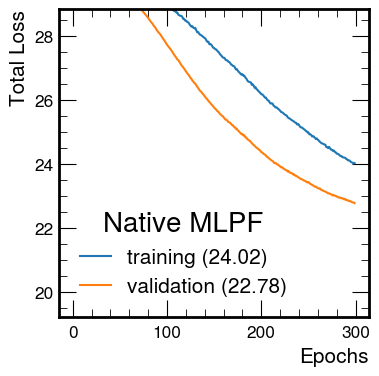

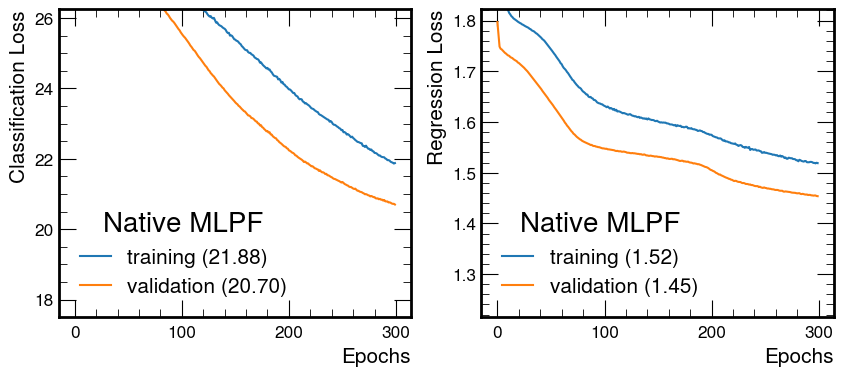

In [34]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)


losses_to_plot["native"]["tot"] = losses_valid_tot
losses_to_plot["native"]["id"] = losses_valid_id
losses_to_plot["native"]["p4"] = losses_valid_momentum    

In [17]:
with open(f"/pfclicvol/losses_to_plot.pkl", "wb") as f:  # dump model architecture
    pkl.dump(losses_to_plot, f, protocol=pkl.HIGHEST_PROTOCOL)

# Compare native vs ssl

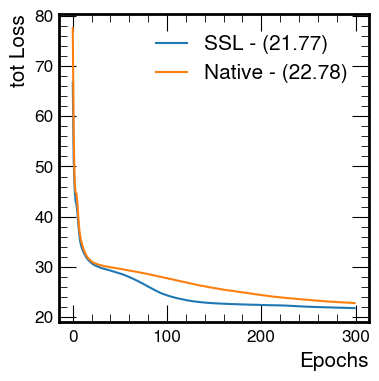

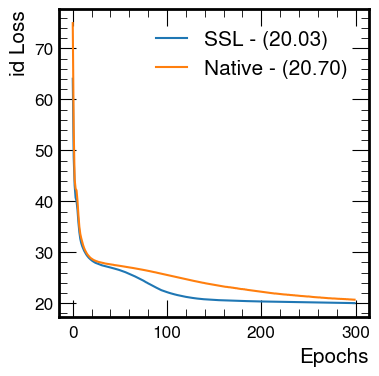

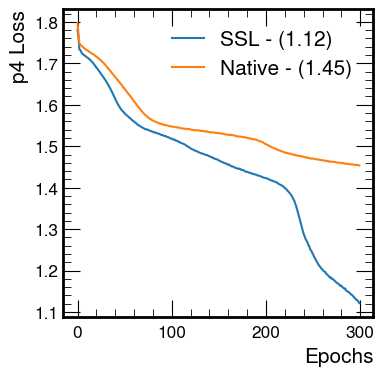

In [35]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

for loss in losses_to_plot["ssl"]:
    # make total loss plot
    fig, ax = plt.subplots(figsize=(4,4))
    ssl = np.array(losses_to_plot["ssl"][loss])
    native = np.array(losses_to_plot["native"][loss])
    ax.plot(range(len(ssl)), ssl, label=f"SSL - ({ssl.min():.2f})")
    ax.plot(range(len(native)), native, label=f"Native - ({native.min():.2f})")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"{loss} Loss")
    ax.legend(loc="best", title_fontsize=20, fontsize=15)